In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

import imblearn
print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix
import itertools


from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_58767/3188123076.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


imblearn version:  0.12.0


# Plotting Functions

In [2]:
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('NEK2 Binding Predictions')

In [3]:
def plot_heatmap(dist, observed_pred, probabilities, title): 
    pred_samples = dist.sample(torch.Size((100,))).exp()
    title = str(title)
    # probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
    probabilities_np = probabilities.numpy()
    class0_prob = probabilities_np[0, :]
    class1_prob = probabilities_np[1, :]
    
    num_samples = class0_prob.shape[0]
    side_length = int(np.ceil(np.sqrt(num_samples)))
    grid_data_class0 = np.full((side_length, side_length), np.nan)
    grid_data_class0.flat[:num_samples] = class0_prob
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    ax[0].imshow(grid_data_class0, cmap='RdYlGn', origin='lower', aspect='equal')
    ax[0].set_title('Probability of Class 0 - '+title)
    ax[0].axis('off');
    fig.colorbar(ax[0].imshow(grid_data_class0, cmap='RdYlGn', origin='lower', aspect='equal'), ax=ax[0], label='Class 0')
    
    # Class 1
    grid_data_class1 = np.full((side_length, side_length), np.nan)
    grid_data_class1.flat[:num_samples] = class1_prob
    ax[1].imshow(grid_data_class1, cmap='RdYlGn', origin='lower', aspect='equal')
    ax[1].set_title('Probability of Class 1 - '+title)
    ax[1].axis('off')
    fig.colorbar(ax[1].imshow(grid_data_class1, cmap='RdYlGn', origin='lower', aspect='equal'), ax=ax[1], label='Class 1')
    fig.suptitle('nek2 binding generated probabilities from posterior distribution- '+title)
    plt.savefig('nek2_binding_probabilities_'+title+'.png')
    plt.show();

In [4]:
def plot_tsne(input, y_true, n_components): 
    tsne = TSNE(n_components=n_components, random_state=42)
    embedded_data = tsne.fit_transform(input)
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=y_true, cmap='viridis')
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(label='Labels')
    plt.show();

In [5]:
def plot_hist(observed_pred, title): 
    var = observed_pred.variance.numpy().tolist()
    # plot class 0 and class 1 sep
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    class0_var = observed_pred.variance[0].numpy()
    class1_var = observed_pred.variance[1].numpy()
    # class 0 
    
    sns.histplot(class0_var, bins=20, kde =True,color ='blue', ax=ax[0])
    # sns.kdeplot(class0_var, color='red', ax=ax[0])
    ax[0].set_title(f'Class 0 Variance Distribution')
    ax[0].set_xlabel('Variance')
    ax[0].set_ylabel('Density')
    ax[0].grid(True)


    # class 1
    sns.histplot(class1_var, bins=20, kde =True, color='green',ax=ax[1])
    # sns.kdeplot(class1_var, color='orange', ax=ax[1])
    ax[1].set_title(f'Class 1 Variance Distribution')
    ax[1].set_xlabel('Variance')
    ax[1].set_ylabel('Density')
    ax[1].grid(True)


    plt.suptitle('NEK2 Binding Distribution of Variances for Each Class -' + title)
    plt.legend()
    plt.grid(True) 
    plt.tight_layout()  
    plt.savefig(f'nek2_binding_variance_dist_{title}.png')
    plt.show();

In [6]:
def plot_variance_cm(observed_pred, true_labels, predictions, title):
    class0_var = observed_pred.variance[0].numpy()
    class1_var = observed_pred.variance[1].numpy()
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, true_pos].numpy()
    var_fn = observed_pred.variance[0, true_neg].numpy()
    
    tp_var0 = class0_var[true_pos]
    tp_var1 = class1_var[true_pos]
    tn_var0 = class0_var[true_neg]
    tn_var1 = class1_var[true_neg]
    fp_var0 = class0_var[false_pos]
    fp_var1 = class1_var[false_pos]
    fn_var0 = class0_var[false_neg]
    fn_var1 = class1_var[false_neg]

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    sns.heatmap([tp_var0, tp_var1], cmap='RdYlBu_r', ax=ax[0, 0])
    ax[0, 0].set_title('True Positives')

    sns.heatmap([tn_var0, tn_var1], cmap='RdYlBu_r', ax=ax[0, 1])
    ax[1, 1].set_title('True Negatives')

    sns.heatmap([fp_var0, fp_var1], cmap='RdYlBu_r', ax=ax[1, 0])
    ax[0, 1].set_title('False Positives')

    sns.heatmap([fn_var0, fn_var1], cmap='RdYlBu_r', ax=ax[1, 1])
    ax[1, 0].set_title('False Negatives')

    plt.suptitle('NEK2 Binding Predictions: Sample Variance - ' + title)
    plt.tight_layout()
    plt.savefig(f'NEK2_binding_heatmap_cm_{title}.png')
    plt.show();

In [7]:
def plot_hist_tp_tn(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, true_pos].numpy()

    plt.figure(figsize=(10,6))
    plt.hist(var_tp, bins=10, alpha=0.5, density=True, label = 'True Positive')
    plt.hist(var_tn, bins=10, alpha=0.5, density=True, label = 'True negative')
    # print(f'tp var: {var_tp}')
    # print(f'tn var: {var_tn}')
    plt.xlabel('Variance')
    plt.legend()
    plt.ylabel('Density')
    plt.title(f'NEK2 Binding Variance Distribution for TP and TN - {title}')
    plt.grid(True)
    plt.savefig(f'nek2_binding_variance_dist_tp_tn_{title}.png')
    plt.show();

In [8]:
def plot_cm_dist(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    print(f'predictions shape: {predictions.shape}')
    print(f'true labels shape: {true_labels.shape}')
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, false_pos].numpy()
    var_fn = observed_pred.variance[0, false_neg].numpy()

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 4)
    plt.hist(var_tp, color='green', alpha=0.7)
    plt.title('True Positives',fontsize=12)
    plt.xlabel('Variance')

    

    plt.subplot(2, 2, 2)
    plt.hist(var_fp, color='red', alpha=0.7)
    plt.title('False Positives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 3)
    plt.hist(var_fn, color='orange', alpha=0.7)
    plt.title('False Negative', fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 1)
    plt.hist(var_tn, color='blue', alpha=0.7)
    plt.title('True Negatives',fontsize=12)
    plt.xlabel('Variance')
    
    plt.tight_layout()
    plt.suptitle(f'NEK2 Binding Variance Distributions - {title}', fontsize=12, y=1.05)

    plt.savefig(f'nek2_var_dist_tptnfpfn_{title}.png')

    plt.show();

In [9]:
def plot_cm_dist_kde(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    print(f'predictions shape: {predictions.shape}')
    print(f'true labels shape: {true_labels.shape}')
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, false_pos].numpy()
    var_fn = observed_pred.variance[0, false_neg].numpy()

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 4)
    sns.histplot(var_tp, kde=True,color='green', bins=10)
    plt.title('True Positives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 1)
    sns.histplot(var_tn, kde=True,color='blue', bins=10)
    plt.title('True Negatives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 2)
    sns.histplot(var_fp, kde=True,color='red', bins=10)
    plt.title('False Positives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 3)
    sns.histplot(var_fn, kde=True, color='orange', bins=10)
    plt.title('False Negative', fontsize=12)
    plt.xlabel('Variance')
    
    plt.tight_layout()
    plt.suptitle(f'NEK2 Binding Variance Distribution - {title}', fontsize=14, y=1.05)

    plt.savefig(f'nek2_binding_var_dist_tptnfpfn_kde{title}.png')

    plt.show();

In [64]:
def plot_cm_dist_kde_scaled(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    print(f'predictions shape: {predictions.shape}')
    print(f'true labels shape: {true_labels.shape}')
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, false_pos].numpy()
    var_fn = observed_pred.variance[0, false_neg].numpy()


    plt.figure(figsize=(10, 10))

    
    ax2 = plt.subplot(2, 2, 1)
    sns.histplot(var_tn, kde=True,color='blue', bins=10, ax=ax2)
    plt.title('True Negatives',fontsize=12)
    plt.xlabel('Variance')


    ax1 = plt.subplot(2, 2, 4, sharey=ax2)
    # plt.subplot(2, 2, 4)
    sns.histplot(var_tp, kde=True,color='green', bins=10, ax=ax1)
    plt.title('True Positives',fontsize=12)
    plt.xlabel('Variance')
    plt.ylim(0, 5)

    ax3 = plt.subplot(2, 2, 2, sharey=ax2)
    sns.histplot(var_fp, kde=True,color='red', bins=10, ax=ax3)
    plt.title('False Positives',fontsize=12)
    plt.xlabel('Variance')
    
    


    ax4 = plt.subplot(2, 2, 3, sharey=ax2)
    sns.histplot(var_fn, kde=True, color='orange', bins=10,ax=ax4)
    plt.title('False Negative', fontsize=12)
    plt.xlabel('Variance')
    
    plt.tight_layout()
    plt.suptitle(f'NEK2 Binding Variance Distribution Scaled - {title}', fontsize=14, y=1.05)

    plt.savefig(f'nek2_binding_cm_kdehist_scaled{title}.png')

    plt.show();

In [11]:
# def plot_violin(observed_pred, title, class_labels = ['0', '1'],y_max = 10): 
#     fig, ax = plt.subplots(1, 2, figsize=(14, 6))


#     class0_var = observed_pred.variance[0].numpy() 
#     # plt.hist(class0_var, bins=20, alpha=0.5, label=f'Class 0')

#     class1_var = observed_pred.variance[1].numpy() 
#     # plt.hist(class1_var, bins=20, alpha=0.5, label=f'Class 1')
#     sns.violinplot(data=var, inner="quartile")
#     # sns.violinplot(data=var, inner="quartile", hue=class_labels)
#     sns.violinplot(x='Class', y='Variance', data=df)
  
#     plt.set_xlabel('Class')

#     plt.grid(True)

    
#     # sns.violinplot(data=class1_var.tolist(), inner="quartile")
#     # plt.xlabel('Class')

#     plt.ylabel('Variance')
#     # plt.ylim(0,y_max)
#     plt.legend()
#     plt.title(f'Binding Variance Distribution - {title}')
#     plt.grid(True)
#     plt.savefig(f'nek2_binding_violin_{title}.png')
#     plt.show();

In [12]:
from sklearn.metrics import roc_curve, auc
def plot_roc(y_true, y_prob):
    y_prob0 = y_prob[0,:]
    y_prob1 = y_prob[1,:]
    fpr0, tpr0, thresholds0 = roc_curve(y_true, y_prob0)
    fpr1, tpr1, thresholds1 = roc_curve(y_true, y_prob1)
    roc_auc0 = auc(fpr0, tpr0)
    roc_auc1 = auc(fpr1, tpr1)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, color='orange', lw=2, label='class 1 ROC curve (area = %0.2f)' % roc_auc0)
    plt.plot(fpr0, tpr0, color='blue', lw=2, label='class 0 ROC curve (area = %0.2f)' % roc_auc0)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('NEK2 Binding ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'NEK2_binding_roc_test.png')
    plt.show(); 


In [13]:
def plot_kde(observed_pred, title): 
    plt.figure(figsize=(8, 6))
    var = observed_pred.variance.numpy().tolist()
    class0_var = observed_pred.variance[0].numpy() 
    class1_var = observed_pred.variance[1].numpy() 
    
    sns.kdeplot(class0_var, label=f'Class 0')
    sns.kdeplot(class1_var, label=f'Class 1')
    plt.xlabel('Variance')
    plt.ylabel('Density')
    plt.title(f'NEK2 Binding Variances for Each Class - {title}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'nek2_binding_kde_plot_{title}.png')
    plt.show();

In [14]:
def plot_prec_recall(y_true, y_pred, title): 
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('NEK2 Binding Precision-Recall Curve')
    plt.grid(True)
    plt.savefig(f'nek2_binding_precision_recall_{title}.png')
    plt.show()

In [15]:
def look_at_data(filepath):
    """5-fold on majority and minority separately, then concat into one df""" 
    df = pd.read_csv(filepath)

    print("Dataset shape:",df.shape)
    print(df.active.value_counts())
    print(df['fold'].unique())
    num_gap = (df.loc[df['active']==0].shape[0]) - (df.loc[df['active']==1].shape[0])
    print("\nDifference in class sample sizes: ",num_gap)

    num_minority = df.loc[df['active']==1].shape[0]
    print("Number of minority samples: ",num_minority)
    # print(df.describe())
    print(f"active/inactive: {df['active'].value_counts()}")
    print(f"active/inactive: {df['active'].value_counts()}")
    counts_per_fold = df.groupby('fold')['active'].value_counts()
    print(counts_per_fold)
    return df

In [16]:
split_path = '../../../data/NEK_data_4Berkeley/NEK2/'
file = 'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv'
all_fold_df = look_at_data(split_path+'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

Dataset shape: (1408, 310)
active
0    1351
1      57
Name: count, dtype: int64
['fold4' 'fold1' 'fold2' 'fold3' 'fold5']

Difference in class sample sizes:  1294
Number of minority samples:  57
active/inactive: active
0    1351
1      57
Name: count, dtype: int64
active/inactive: active
0    1351
1      57
Name: count, dtype: int64
fold   active
fold1  0         271
       1          12
fold2  0         270
       1          12
fold3  0         270
       1          11
fold4  0         270
       1          11
fold5  0         270
       1          11
Name: count, dtype: int64


In [17]:
# train fold 1
split_path = "../../../data/datasets/NEK_data_4Berkeley/NEK2"
# /Users/jayceepang/msse/capstone/data/NEK_data_4Berkeley/NEK2/NEK2_binding_random_fold1_testY.csv

train_x_df_temp = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainX.csv")
train_y_df_temp = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainY.csv")
test_x_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_testX.csv")
test_y_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_testY.csv")

In [18]:
train_y_df_temp[train_y_df_temp['active']==1].shape
train_y_df_temp[train_y_df_temp['active']==0].shape
1080+45

1125

In [19]:
# SMOTE: Adjust imbalanced training data

# transform the dataset
oversample = SMOTE()
new_train_x_df, new_train_y_df = oversample.fit_resample(train_x_df_temp, train_y_df_temp)

# display(new_train_x_df.head)

display("original training size: ",train_x_df_temp.shape)
# display(train_y_df_temp.value_counts())
display("SMOTE train set size:",new_train_y_df.shape)
# new_train_x_df['active'].value_counts
# display(new_train_y_df.value_counts())



# SMOTE 

1351+57
# new_inactives = new_train_y_df[new_train_y_df['active'] == 0] 
# new_actives = new_train_y_df[new_train_y_df['active'] == 1] 
# print(f'shape new inactives: {new_inactives.shape}')
# print(f'shape new actives: {new_actives.shape}')

'original training size: '

(1125, 306)

'SMOTE train set size:'

(2160, 1)

1408

In [20]:
# save to files 

train_x_df = new_train_x_df
train_y_df = new_train_y_df

train_x_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_trainX.csv", index=False)
train_y_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_trainY.csv", index=False)
test_x_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_testX.csv", index=False)
test_y_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_testY.csv", index=False)


# test_inactive = test_x_df[test_y_df['active']==0]
# test_active = test_x_df[test_y_df['active']==1]
# print(test_inactive.shape, test_active.shape)

# train_inactive = train_x_df[train_y_df['active']==0]
# train_active = train_y_df[train_y_df['active']==1]
# print(train_inactive.shape, train_active.shape)
# 1080+

In [21]:
# Transform data to PyTorch tensors

# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_scaled_data = scaling.transform(train_x_df)
test_scaled_data = scaling.transform(test_x_df) 
# print(f"train x value counts: {new_train_x_df['active'].value_counts}")
# print(f"test y value counts: {test_y_df['active'].value_counts}")

train_x_temp = train_scaled_data.astype("long")
test_x_temp = test_scaled_data.astype("long")

train_y_temp = train_y_df.to_numpy().flatten().astype("long")
test_y_temp = test_y_df.to_numpy().flatten().astype("long")


train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp)
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp)


print(train_x.shape) 
print(train_y.shape) 


torch.Size([2160, 306])
torch.Size([2160])


In [22]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [23]:
class Trainer: 
    def __init__(self,model, likelihood, iterations): 
        self.model = model
        self.likelihood = likelihood 

        smoke_test = ('CI' in os.environ)
        self.n_iterations = 2 if smoke_test else iterations
        # self.n_iterations = n_iterations 
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        # loss function 
        self.loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)
    def train(self, train_x, train_y): 
        self.model.train()
        self.likelihood.train()
        predictions = [] 
        for i in range(self.n_iterations): 
            self.optimizer.zero_grad()
            output = self.model(train_x)
            loss = -self.loss_fn(output, self.likelihood.transformed_targets).sum()
            loss.backward()
            if (i%10==0): 
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, self.n_iterations, loss.item(),
                    self.model.covar_module.base_kernel.lengthscale.mean().item(),
                    self.model.likelihood.second_noise_covar.noise.mean().item()
                ))
             
          
            self.optimizer.step() 

            

    def predict(self, input): 
        # predict on validation set? 
        self.model.eval()
        self.likelihood.eval()

        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            dist = self.model(input)     # get predicted distributions 
            pred_means = dist.loc          # extract means for predicted dist
            # f_samples = dist.sample(sample_shape=torch.Size(1000))    
            observed_pred = self.likelihood(self.model(input))    # likelihood predictions 
            class_pred = self.model(input).loc.max(0)[1].numpy() 
        return dist, observed_pred, pred_means,class_pred
    

    def evaluate(self, x_input, y_true, class_names, plot_name): 
        
        y_pred = self.model(x_input).loc.max(0)[1].numpy() 

        cm = confusion_matrix(y_true, y_pred)
        plt.rcParams.update({"font.size": 20})
        label_font = {'size':'18'} 
        ax = plt.figure(figsize=(5,5))
        plt.title(plot_name,fontsize=20)
        plot_confusion_matrix(cm, classes=class_names, normalize=False)
        plt.xlabel("Predicted",fontdict=label_font);
        plt.ylabel("Actual",fontdict=label_font);
        return y_pred
    
    
    def get_metrics(self, x, y_true, y_pred): 
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        dist = self.model(x)     # get predicted distributions 
        pred_means = dist.loc          # means for predicted dist 
        # pred_probs = self.likelihood(dist).probs #predicted probabilities 
        # f_mean = dist.mean
        # f_var = dist.variance
        # f_covar = dist.covariance_matrix
        # f_samples = dist.sample(sample_shape=torch.Size(1000))    
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        
        # # roc_auc = roc_auc_score(y_true, y_pred_proba) 
        # # fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_proba)
        # # roc_auc_curve = auc(fpr, tpr)
        # # precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_proba)
        # # pr_auc_curve = auc(recall, precision)
        
        
        return accuracy, precision, f1, recall 
            

In [24]:
likelihood1 = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model1 = DirichletGPModel(train_x, likelihood1.transformed_targets, likelihood1, num_classes=likelihood1.num_classes)
n_iterations = 300
trainer1 = Trainer(model1, likelihood1, n_iterations)
trainer1.train(train_x, train_y) 

Iter 1/300 - Loss: 7.038   lengthscale: 0.693   noise: 0.693
Iter 11/300 - Loss: 5.761   lengthscale: 1.321   noise: 1.288
Iter 21/300 - Loss: 5.030   lengthscale: 2.203   noise: 1.829
Iter 31/300 - Loss: 4.602   lengthscale: 3.274   noise: 1.904
Iter 41/300 - Loss: 4.275   lengthscale: 4.333   noise: 1.499
Iter 51/300 - Loss: 3.974   lengthscale: 5.286   noise: 0.884
Iter 61/300 - Loss: 3.770   lengthscale: 6.043   noise: 0.401
Iter 71/300 - Loss: 3.643   lengthscale: 6.588   noise: 0.173
Iter 81/300 - Loss: 3.578   lengthscale: 6.960   noise: 0.090
Iter 91/300 - Loss: 3.554   lengthscale: 7.203   noise: 0.057
Iter 101/300 - Loss: 3.531   lengthscale: 7.352   noise: 0.042
Iter 111/300 - Loss: 3.535   lengthscale: 7.439   noise: 0.033
Iter 121/300 - Loss: 3.531   lengthscale: 7.490   noise: 0.027
Iter 131/300 - Loss: 3.516   lengthscale: 7.524   noise: 0.023
Iter 141/300 - Loss: 3.509   lengthscale: 7.546   noise: 0.020
Iter 151/300 - Loss: 3.508   lengthscale: 7.564   noise: 0.018
Ite

In [25]:
# get predictions of train x input
train_dist, train_observed_pred, train_pred_means, train_pred  = trainer1.predict(train_x)
# print(f'pred means shape: {train_pred_means.numpy().shape}')
print(f'train predictions: {train_pred}')
print(f'train prediction means: {train_pred_means}')

print(train_pred_means.shape)
train_accuracy, train_precision, train_f1, train_recall = trainer1.get_metrics(train_x, train_y, train_pred)
print(f'accuracy: {train_accuracy}, precision: {train_precision}, f1: {train_f1}, recall: {train_recall}')
# plot_tsne(train_x, train_y, 3)

/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


train predictions: [0 0 0 ... 1 1 1]
train prediction means: tensor([[-0.2531, -0.6397, -0.2794,  ..., -5.6698, -6.8844, -6.0156],
        [-6.9305, -5.1170, -6.8914,  ..., -0.5098, -0.1281, -0.6300]])
torch.Size([2, 2160])


/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


accuracy: 0.999537037037037, precision: 0.9990749306197965, f1: 0.999537251272559, recall: 1.0


Confusion matrix, without normalization
[[1079    1]
 [   0 1080]]


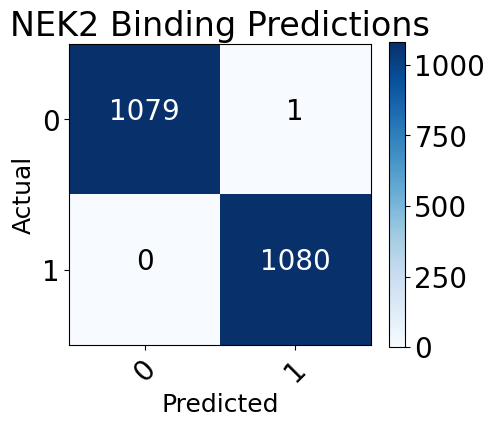

In [26]:
train_cm = confusion_matrix(train_y, train_pred)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 binding train set",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

plt.savefig('nek2_binding_cm_train.png')

In [113]:
# Make predictions on test set  
test_dist, test_observed_pred, test_pred_means, test_pred  = trainer1.predict(test_x)

# print(f'test predictions: {test_pred}')
# print(f'test prediction means: {test_pred_means}')
# print(test_pred_means.shape)
test_accuracy, test_precision, test_f1, test_recall = trainer1.get_metrics(test_x, test_y, test_pred)
print(f'accuracy: {test_accuracy}, precision: {test_precision}, f1: {test_f1}, recall: {test_recall}')
print(type(test_pred_means))


accuracy: 0.9575971731448764, precision: 0.5, f1: 0.3333333333333333, recall: 0.25
<class 'torch.Tensor'>


Confusion matrix, without normalization
[[268   3]
 [  9   3]]


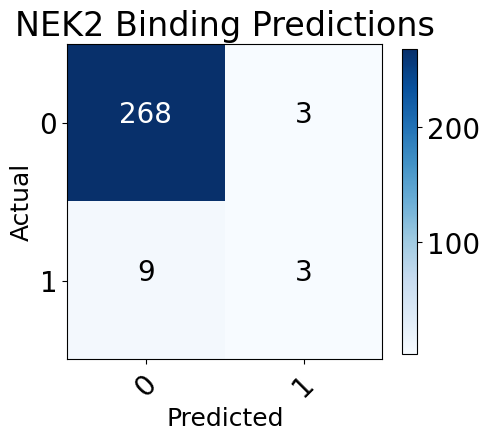

In [88]:
test_cm = confusion_matrix(test_y, test_pred)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 binding test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);
plt.savefig('nek2_binding_cm_test.png')

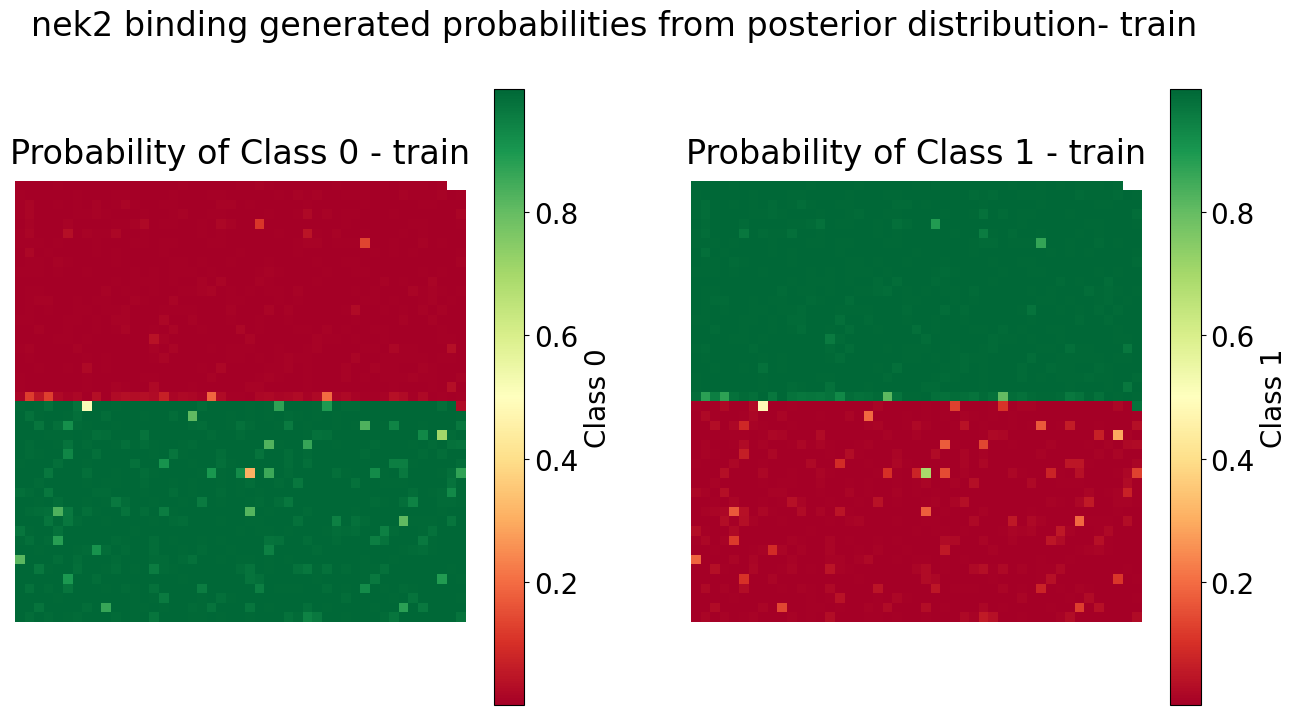

In [29]:
# get train samples 
train_pred_samples = train_dist.sample(torch.Size((256,))).exp()
train_probabilities = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).mean(0)
train_probabilities.shape 
# TRAIN
plot_heatmap(train_dist, train_observed_pred, train_probabilities, 'train')

In [30]:
train_probabilities

tensor([[0.9986, 0.9852, 0.9984,  ..., 0.0059, 0.0014, 0.0047],
        [0.0014, 0.0148, 0.0016,  ..., 0.9941, 0.9986, 0.9953]])

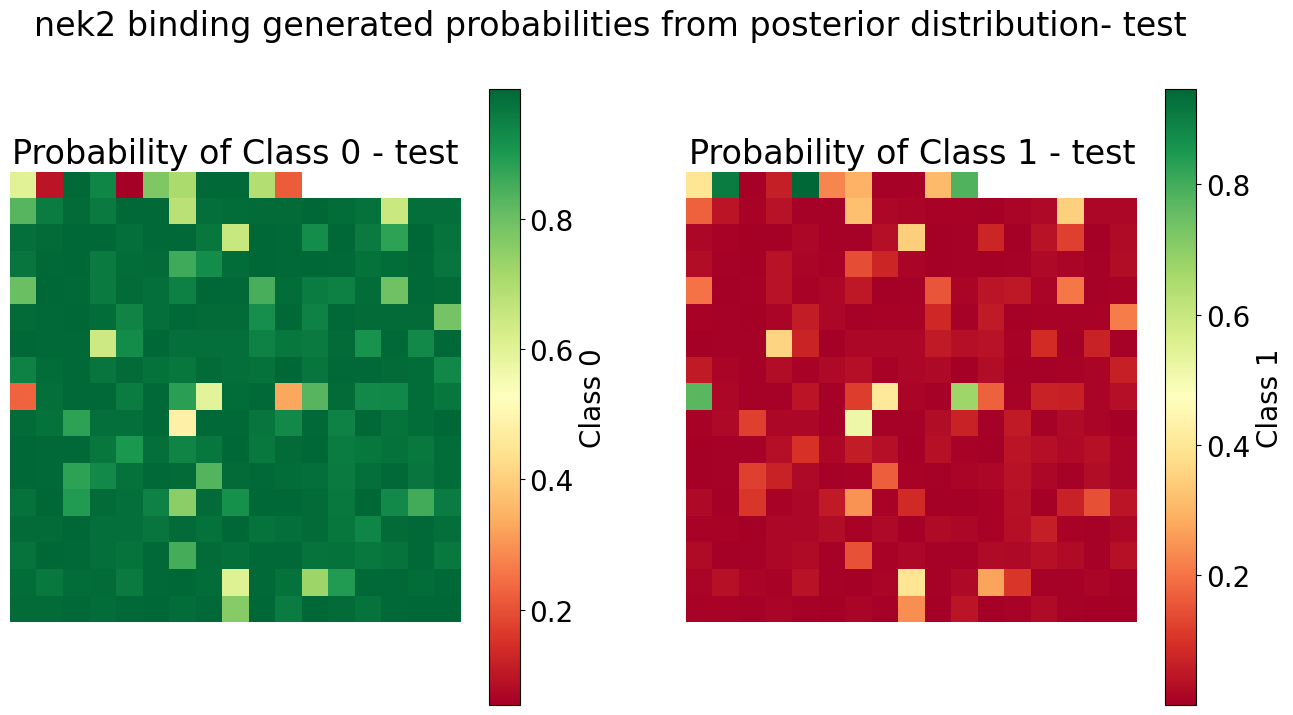

In [31]:
# TEST SET
# # Get confidence regions 
# confidence 
lower, upper = test_observed_pred.confidence_region()

# # Generate samples to get probabilities
pred_samples = test_dist.sample(torch.Size((100,))).exp()
pred_samples.shape
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
plot_heatmap(test_dist, test_observed_pred, probabilities, 'test')

In [32]:
probabilities.shape

torch.Size([2, 283])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


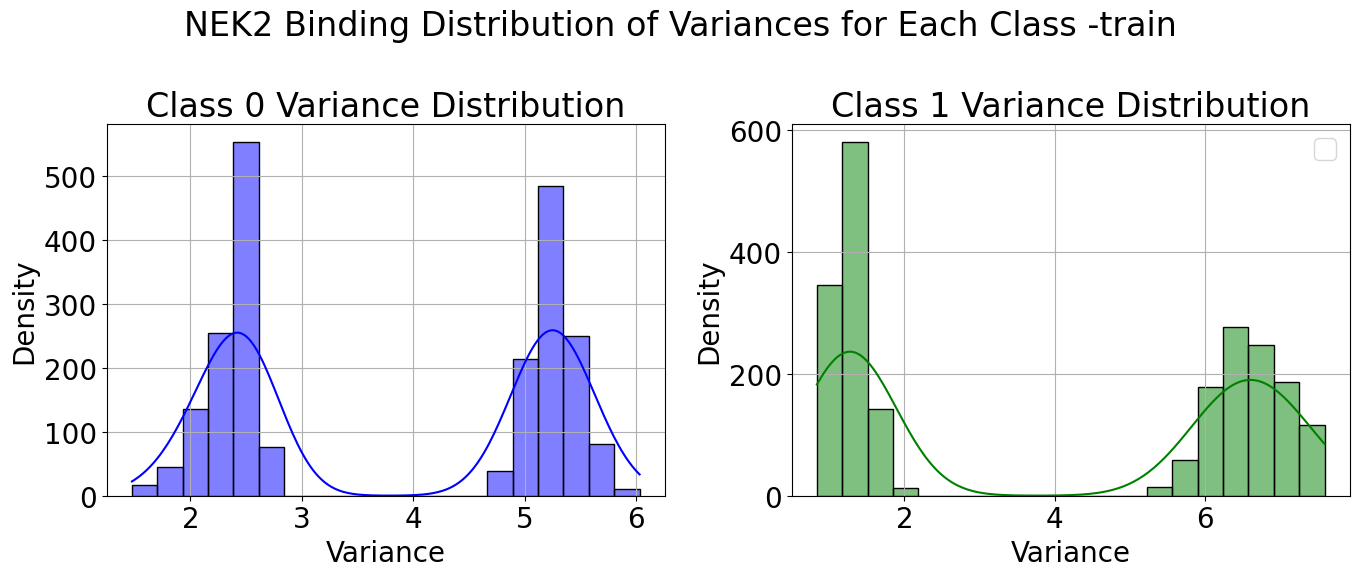

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


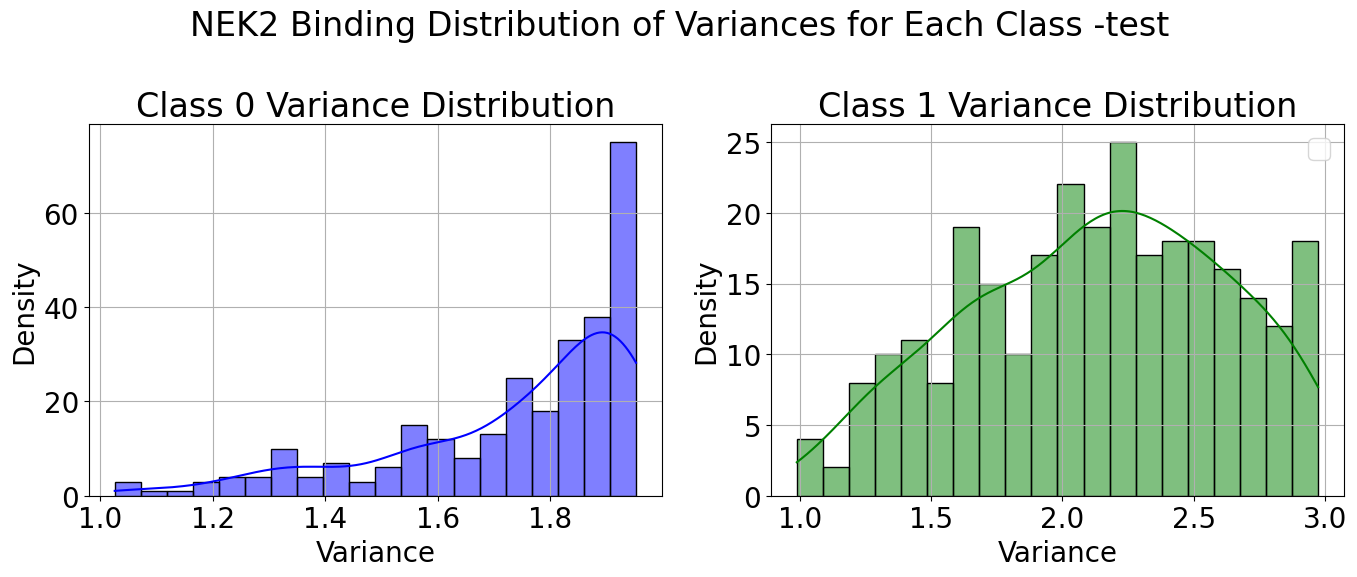

In [33]:
plot_hist(train_observed_pred, 'train')
plot_hist(test_observed_pred, 'test')

predictions shape: (2160,)
true labels shape: (2160,)


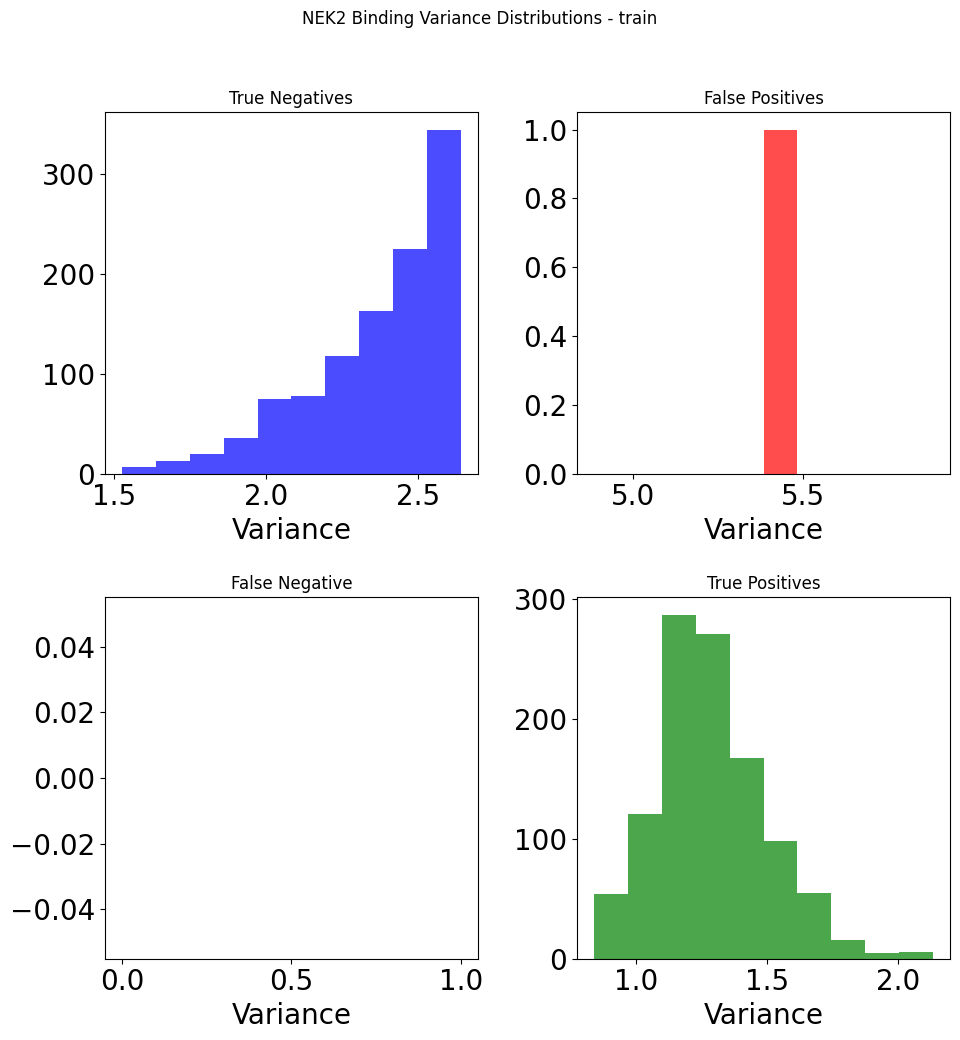

predictions shape: (283,)
true labels shape: (283,)


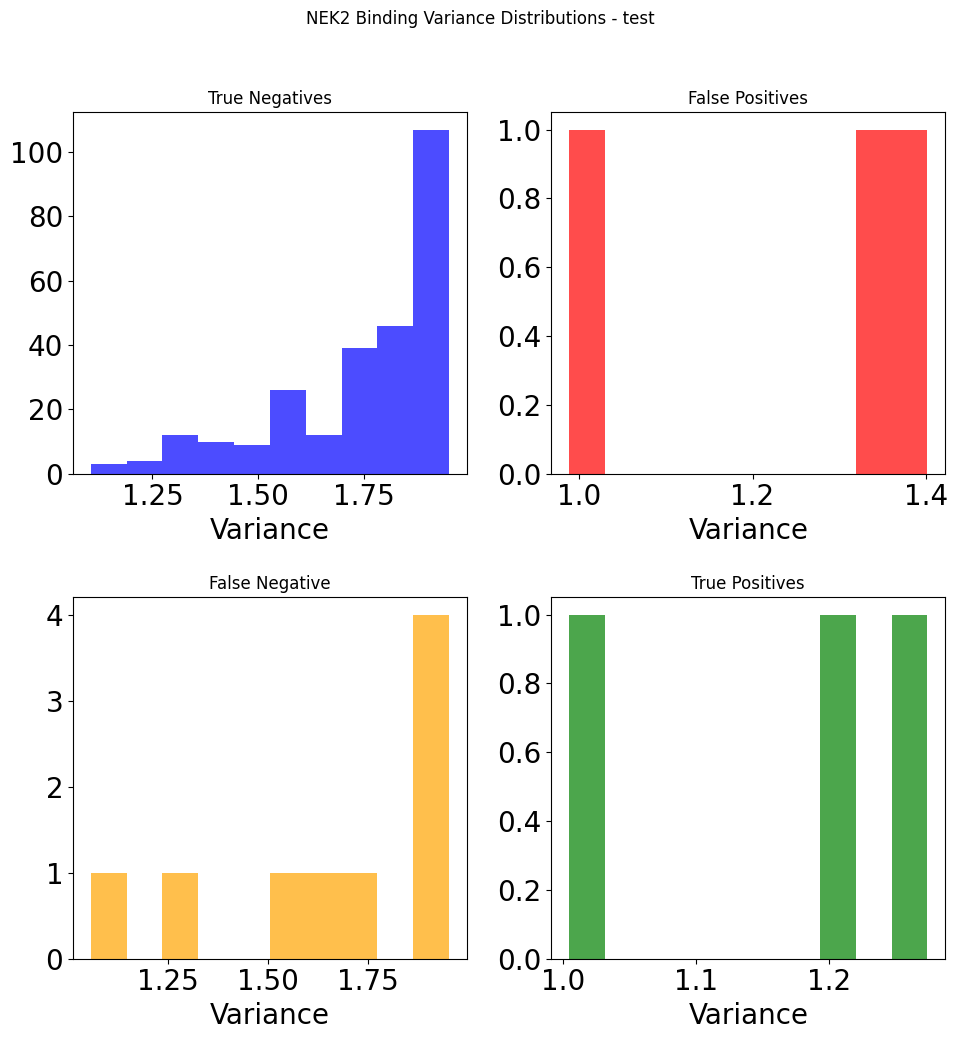

In [35]:
plot_cm_dist(train_observed_pred, train_pred, train_y, 'train')
plot_cm_dist(test_observed_pred, test_pred, test_y, 'test')


predictions shape: (2160,)
true labels shape: (2160,)


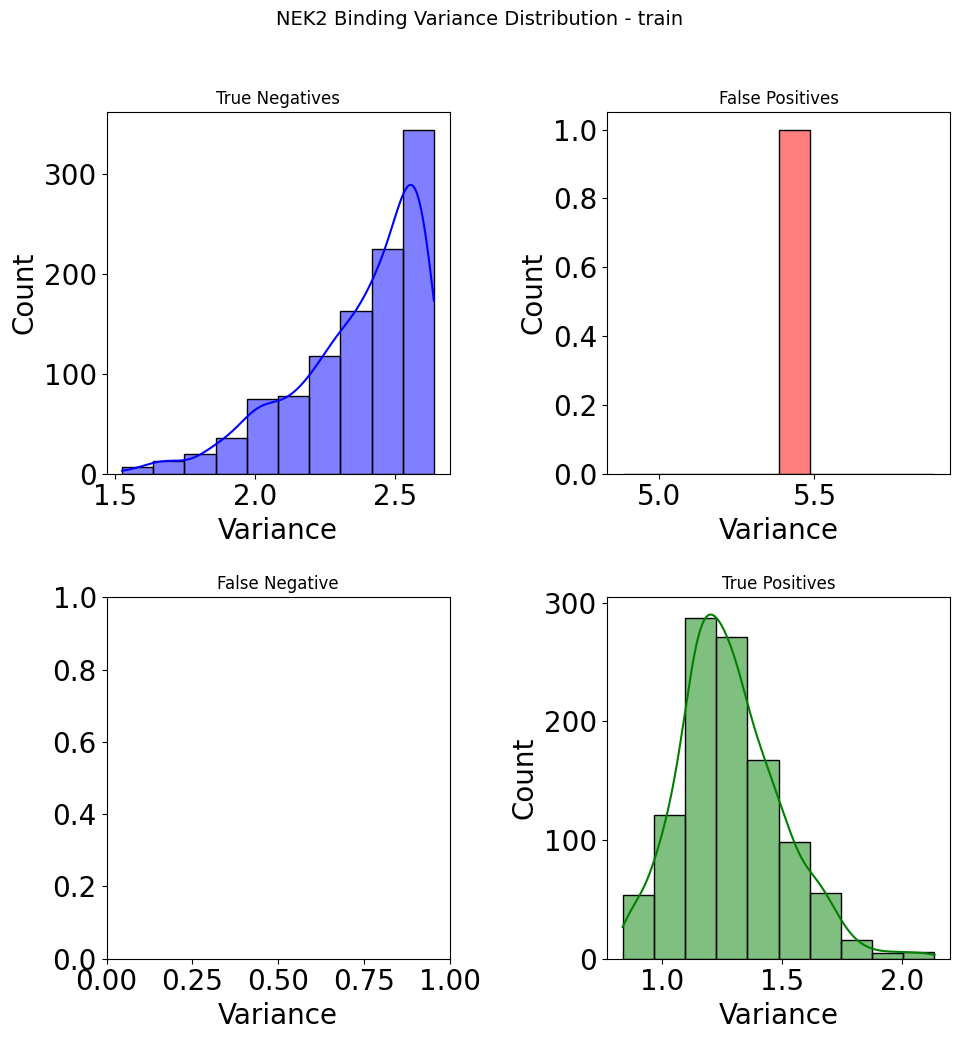

predictions shape: (283,)
true labels shape: (283,)


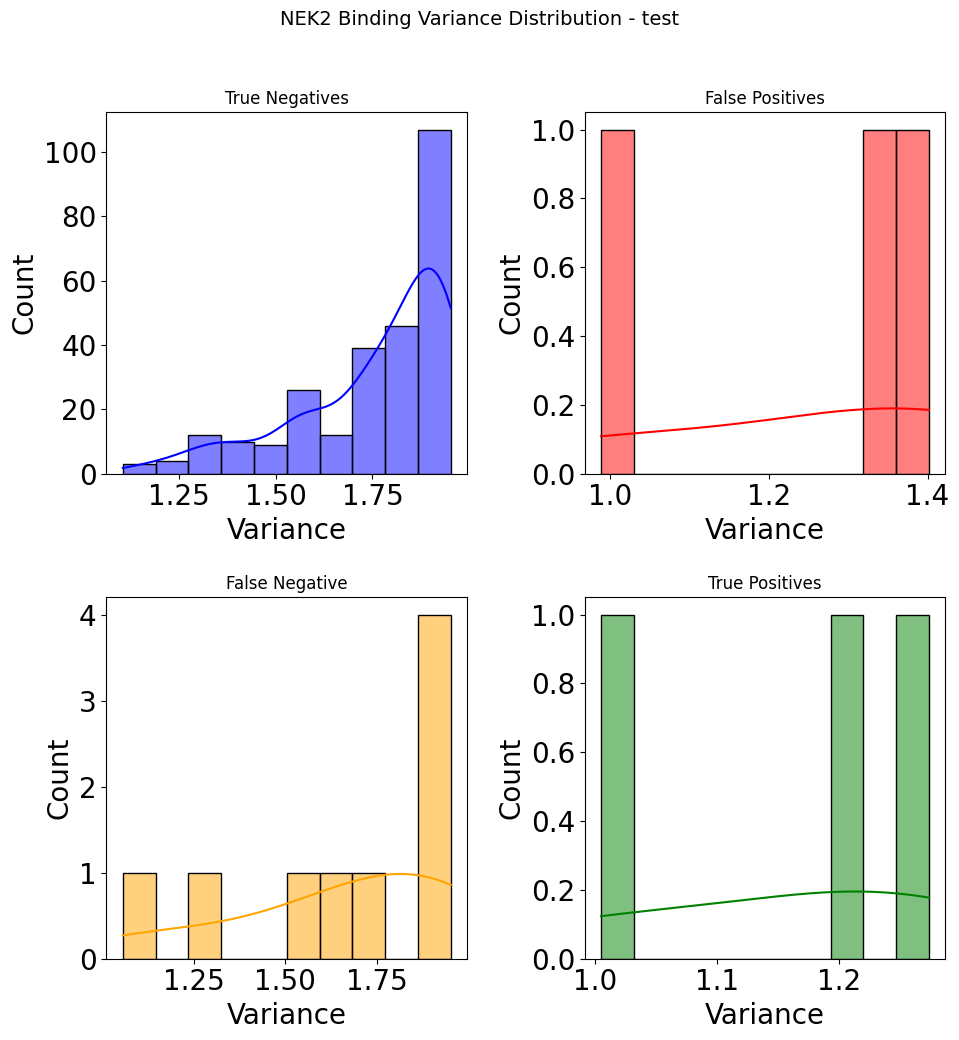

In [36]:
plot_cm_dist_kde(train_observed_pred, train_pred, train_y, 'train')
plot_cm_dist_kde(test_observed_pred, test_pred, test_y, 'test')

predictions shape: (283,)
true labels shape: (283,)


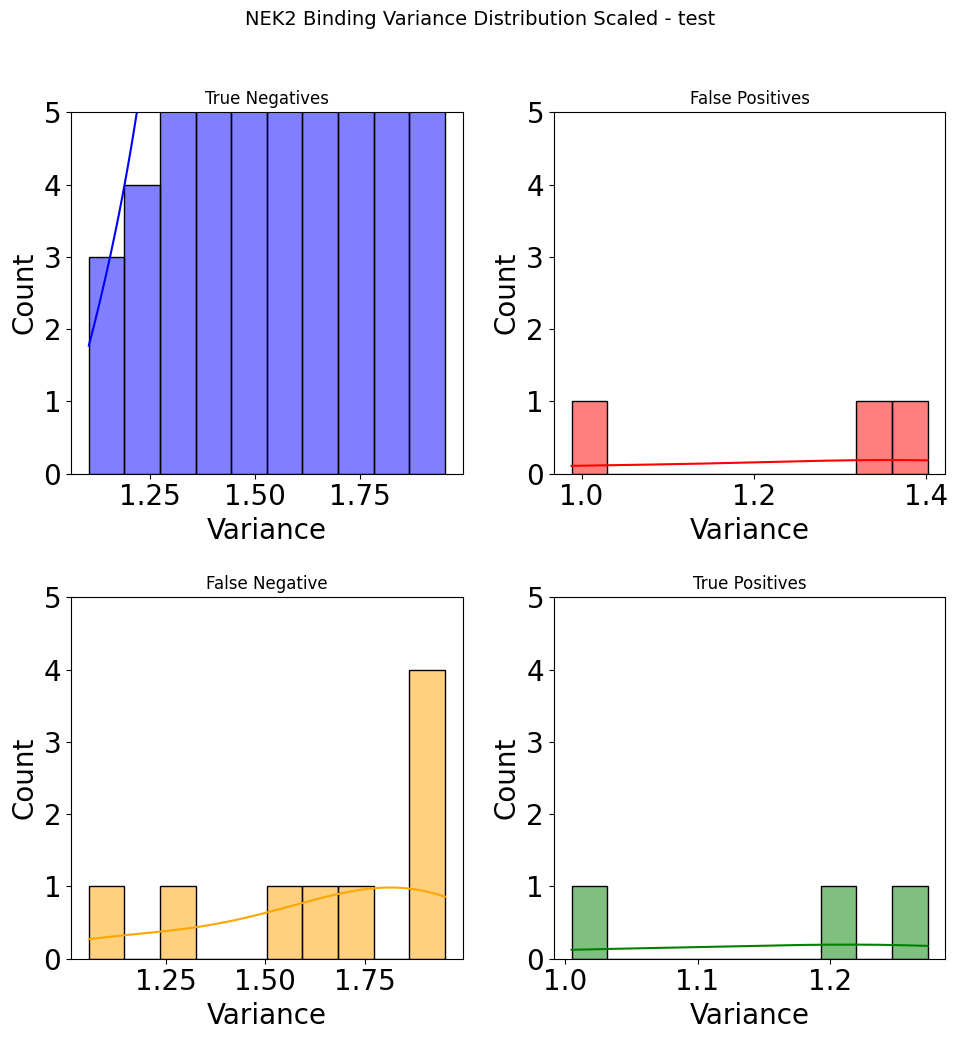

predictions shape: (283,)
true labels shape: (283,)


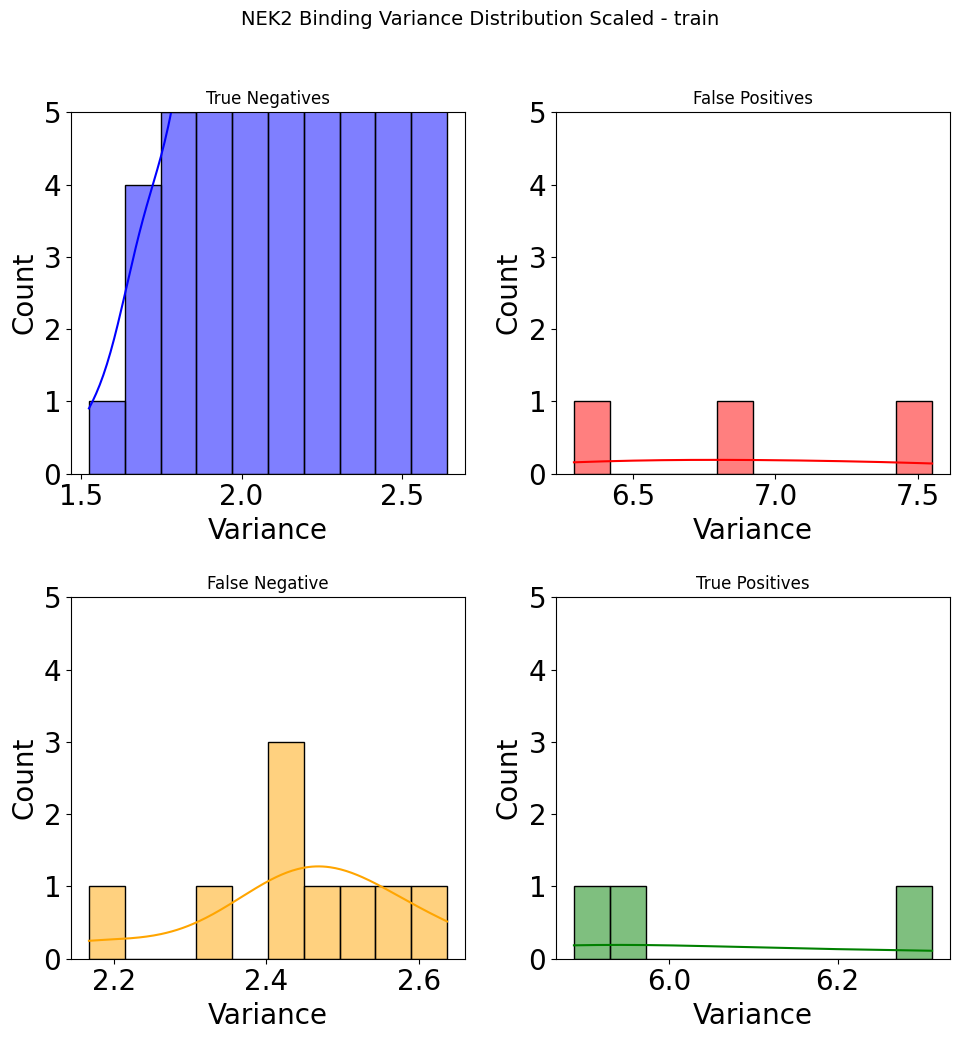

In [65]:
plot_cm_dist_kde_scaled(test_observed_pred, test_pred, test_y, 'test')
plot_cm_dist_kde_scaled(train_observed_pred, test_pred, test_y, 'train')

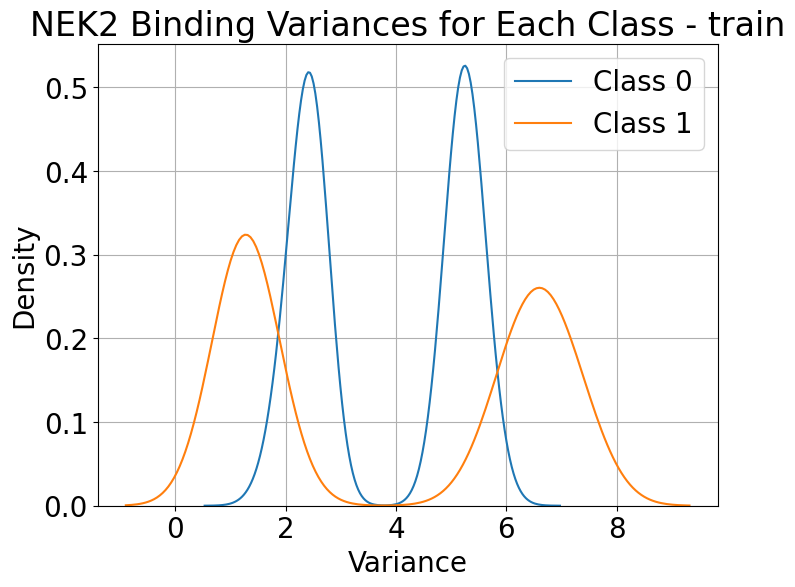

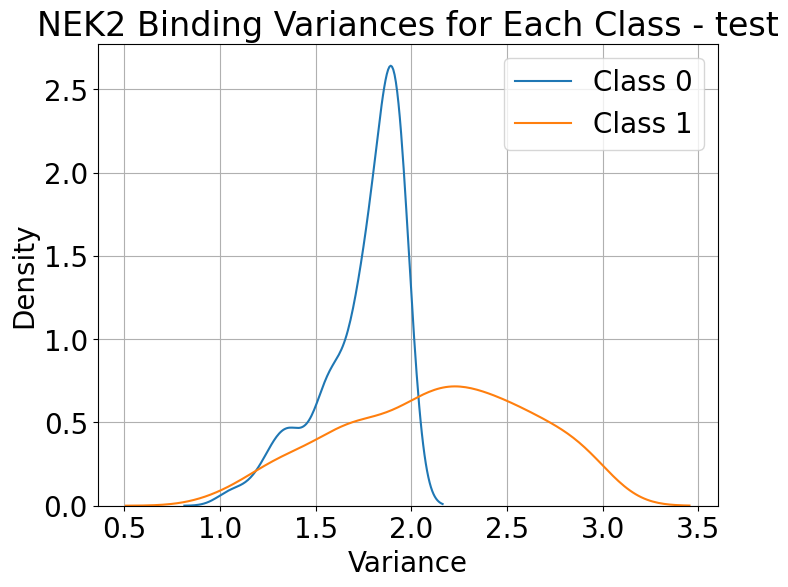

In [38]:
plot_kde(train_observed_pred, 'train')
plot_kde(test_observed_pred, 'test')
# plot_hist(test_observed_prt')

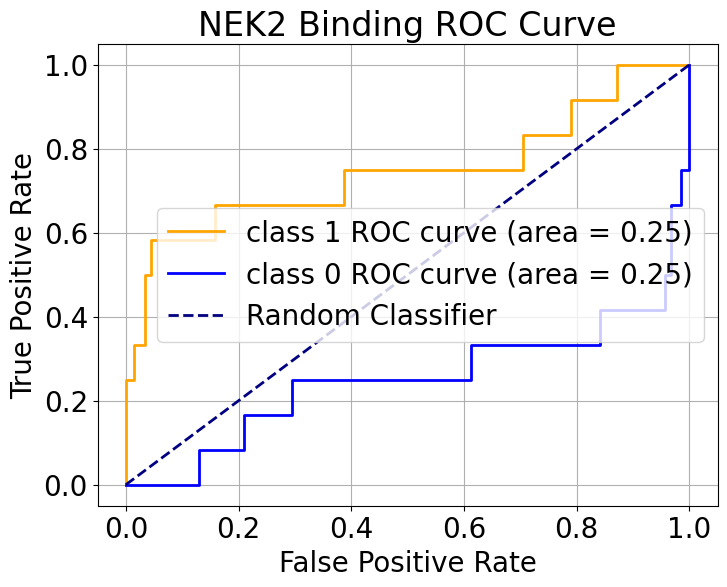

In [39]:
plot_roc(test_y, probabilities)

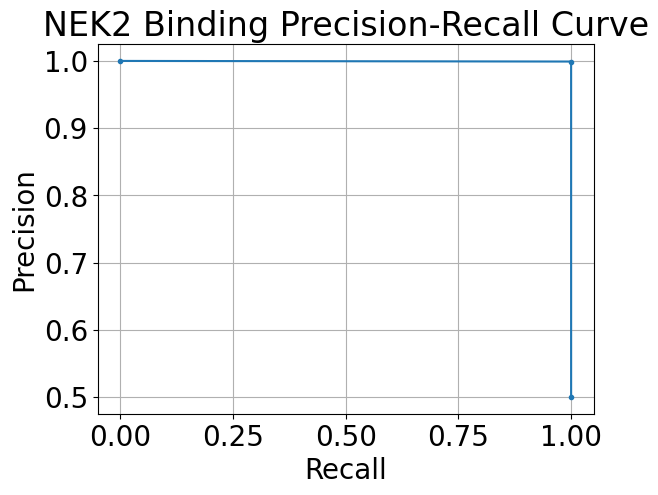

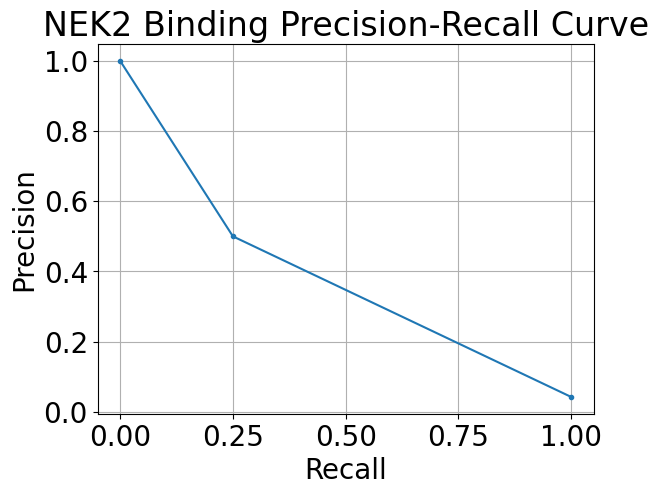

In [40]:
plot_prec_recall(train_y, train_pred, 'train')
plot_prec_recall(test_y, test_pred, 'test')

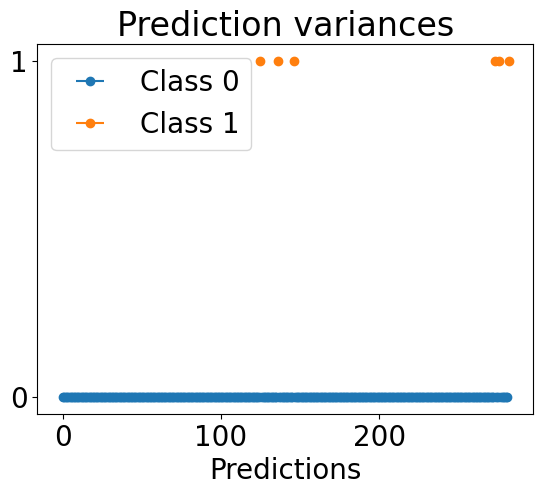

In [41]:
indices0 = np.where(test_pred == 0)[0]
indices1 = np.where(test_pred == 1)[0]

var_class0 = test_observed_pred.variance[0].numpy()
var_class1 = test_observed_pred.variance[1].numpy()
plt.errorbar(indices0, test_pred[indices0], 
             xerr=var_class0[indices0], fmt='o', label='Class 0')

plt.errorbar(indices1, test_pred[indices1], 
             xerr=var_class1[indices1], fmt='o', label='Class 1')


plt.xlabel('Predictions')
plt.yticks([0, 1], ['0', '1'])
plt.title('Prediction variances')
plt.legend()
plt.show()

In [42]:
# plot_violin(train_observed_pred, 'train')

In [43]:
# plot_violin(test_observed_pred, 'test', 4)

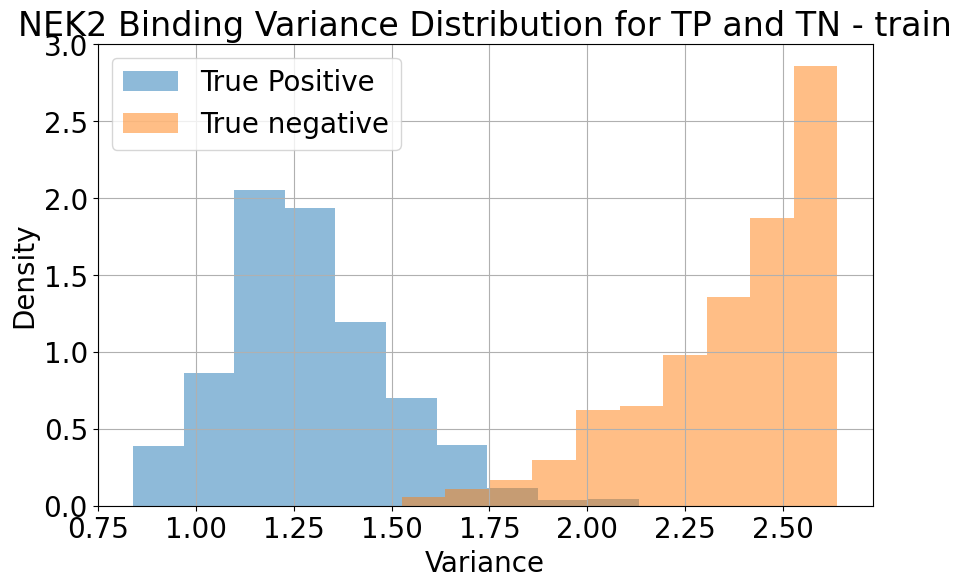

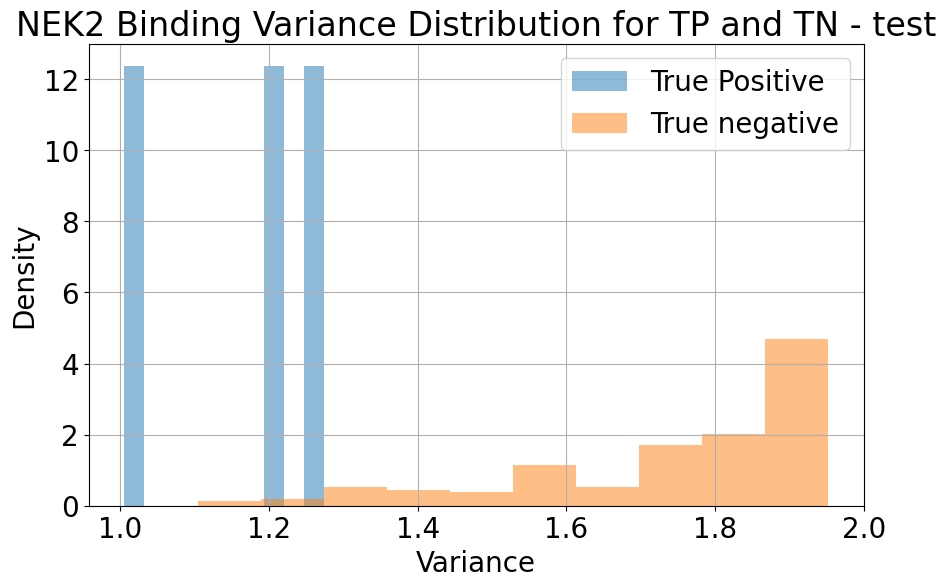

In [44]:
plot_hist_tp_tn(train_observed_pred, train_pred, train_y, 'train')
plot_hist_tp_tn(test_observed_pred, test_pred, test_y, 'test')

In [45]:
indices = np.where(test_pred == 1)[0]
# indices # array([136, 146, 273, 276, 282]) compared to: 
# tutorial: array([125, 136, 146, 273, 276, 282]) 

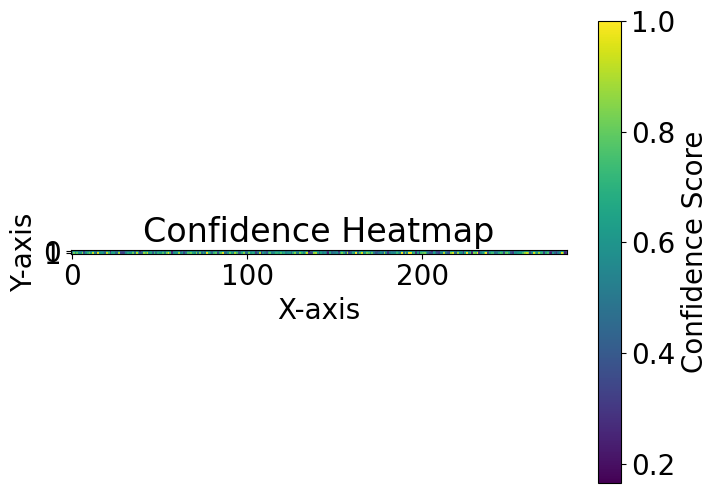

In [46]:
dist = trainer1.model(test_x)
pred_varainces = dist.variance
normalized = pred_varainces/pred_varainces.max() 
normalized.shape
plt.figure(figsize=(8, 6))
plt.imshow(normalized.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Confidence Score')
plt.title('Confidence Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [87]:
test_observed_pred.mean.numpy() # test_pred.mean.numpy()  observed_pred = self.likelihood(self.model(input)) 
# pred_means = dist.loc
test_pred_variance2D = test_observed_pred.variance.numpy()
# print(test_observed_pred.variance.numpy().shape)
test_pred_variance2D
test_pred_variance = [test_pred_variance2D[value][idx] for idx,value in enumerate(test_pred)]
# test_pred_variance

In [48]:
var_min = test_pred_variance2D.min(axis=0).min()
var_max = test_pred_variance2D.max(axis=0).max()
print(var_min, var_max)
test_pred_variance2D.mean()


0.98835933 2.9737208


1.934658

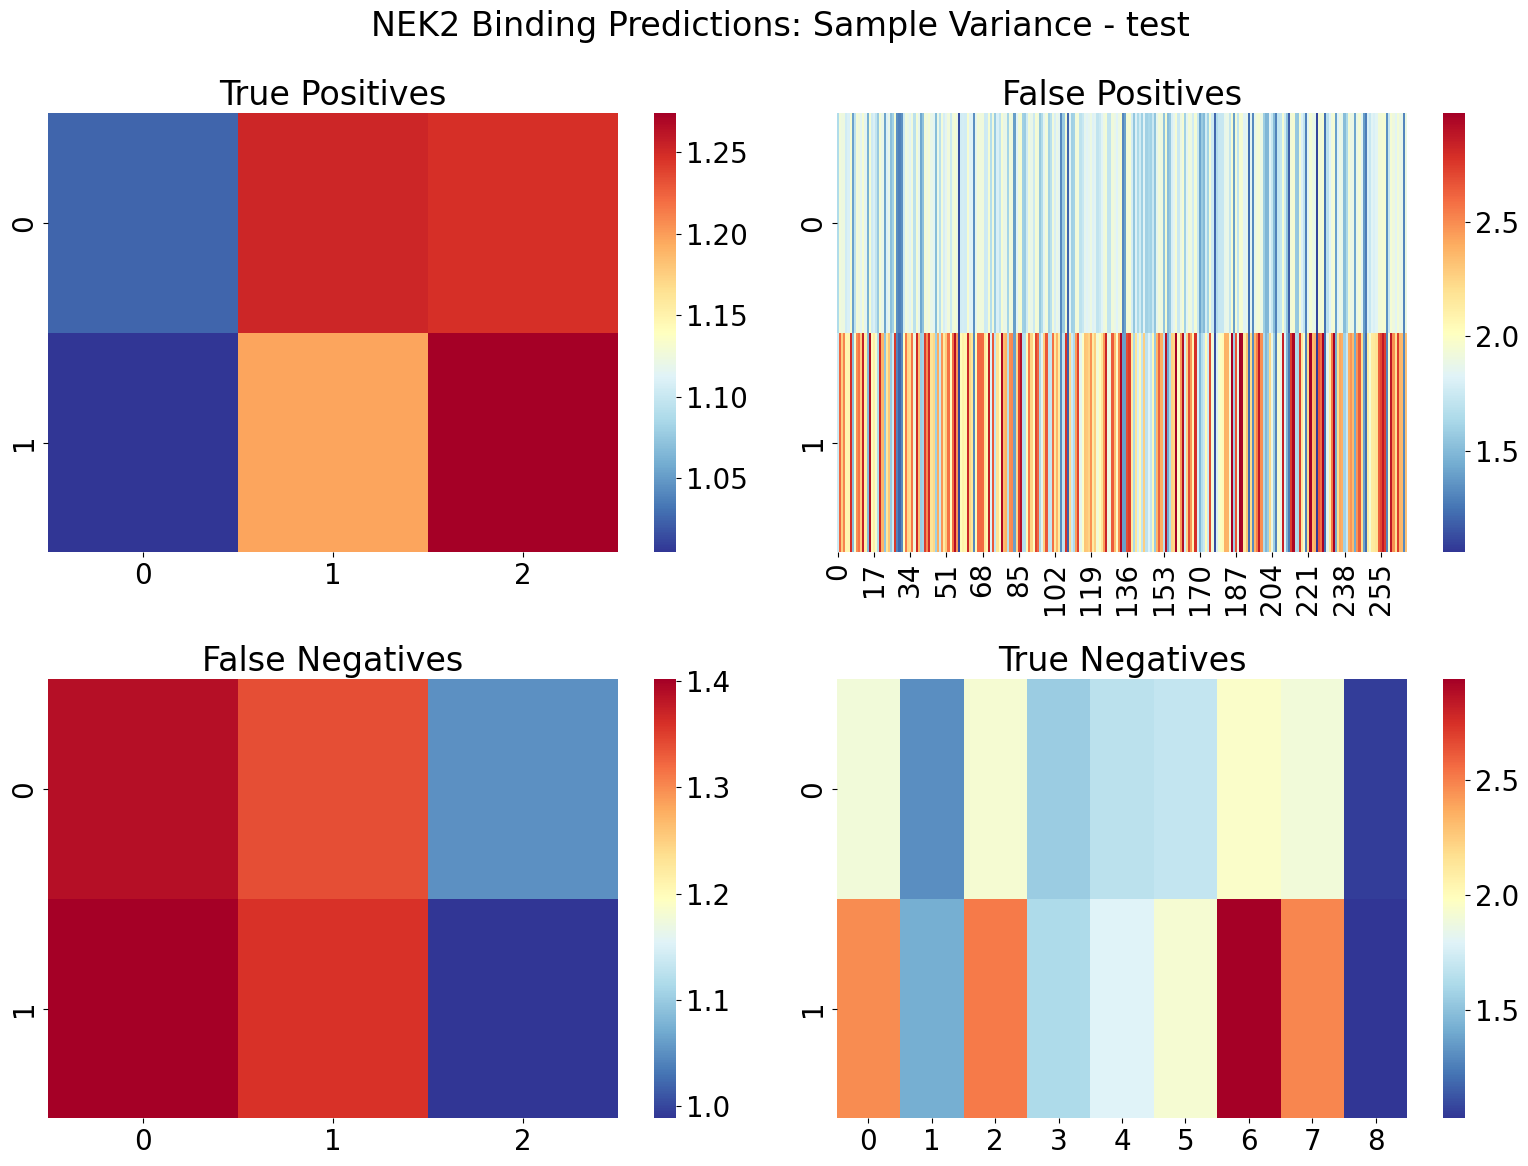

In [49]:
plot_variance_cm(test_observed_pred, test_y.numpy(), test_pred, 'test')

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_58767/4251660063.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


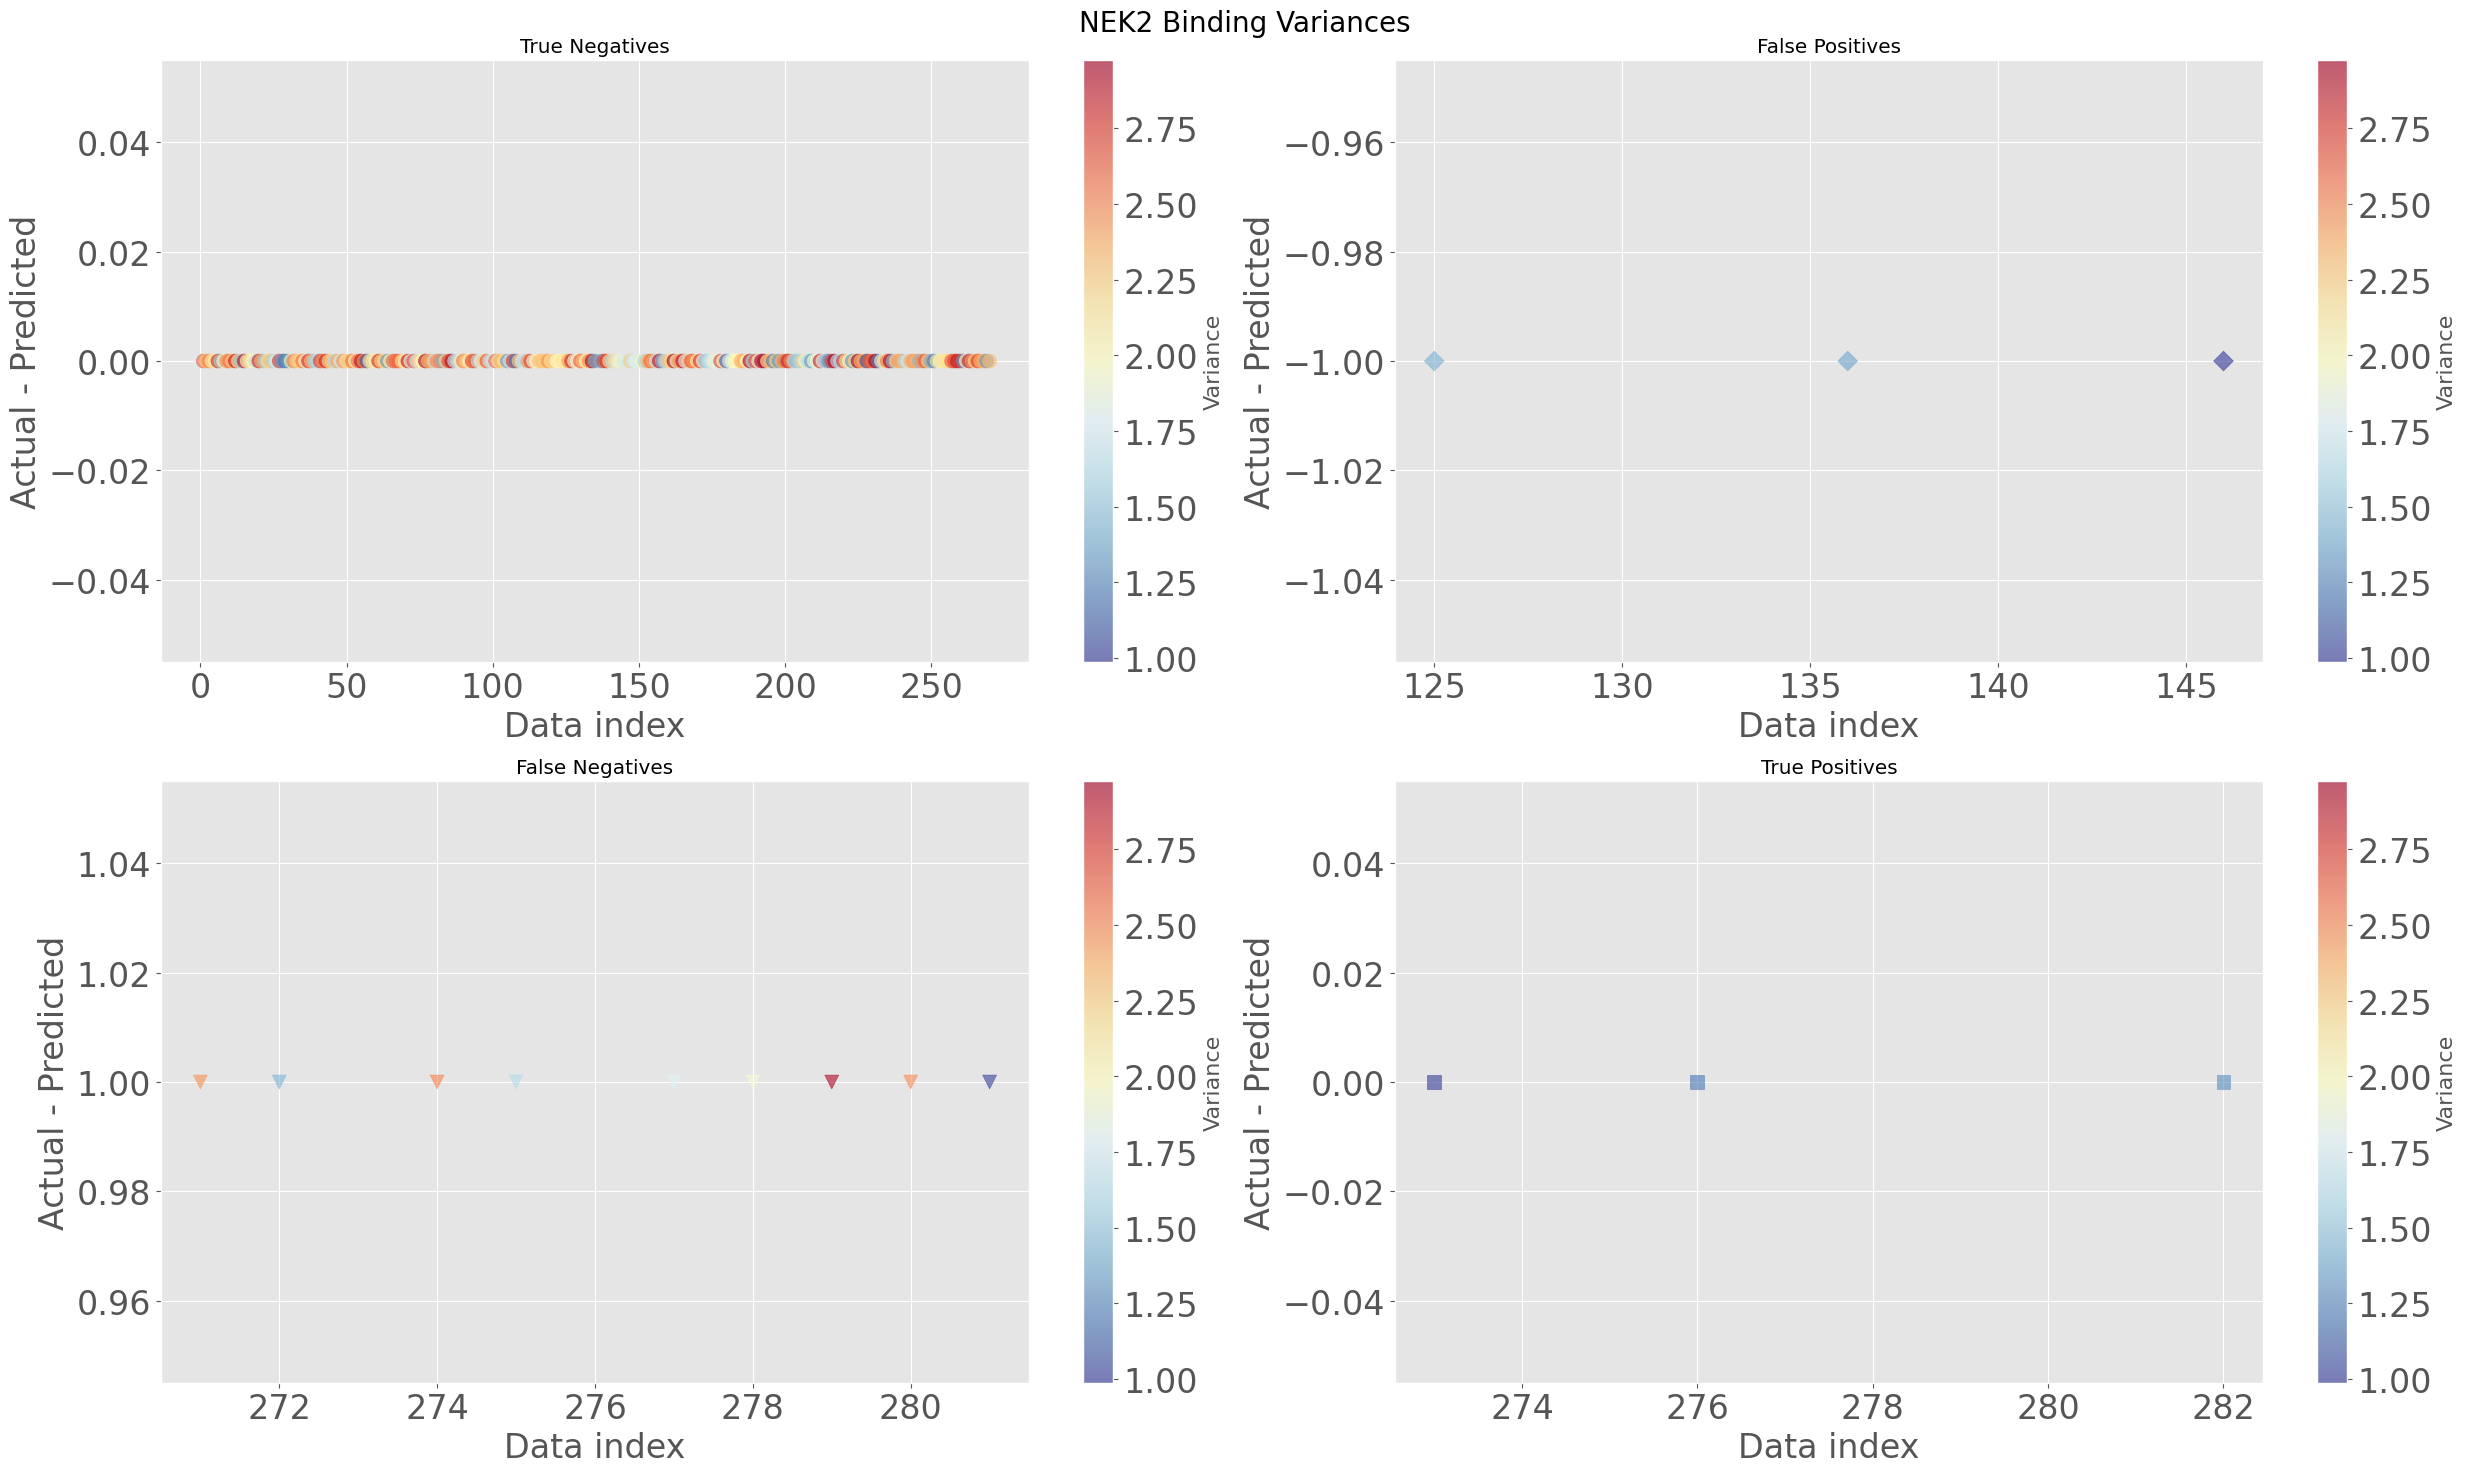

In [114]:
marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig, ax = plt.subplots(2, 2, figsize=(25, 15))
true_labels = test_y.numpy()


true_pos = np.where((test_pred == 1) & (true_labels == 1))[0] 
true_neg = np.where((test_pred == 0) & (true_labels == 0))[0]
false_pos = np.where((test_pred == 1) & (true_labels == 0))[0] 
false_neg = np.where((test_pred == 0) & (true_labels == 1))[0] 

var_tp = test_observed_pred.variance[1, true_pos].numpy()
var_tn = test_observed_pred.variance[0, true_neg].numpy()
var_fp = test_observed_pred.variance[1, false_pos].numpy()
var_fn = test_observed_pred.variance[0, false_neg].numpy()

sc_tp = ax[1, 1].scatter(true_pos, (test_y[true_pos] - test_pred[true_pos]), c=test_pred_variance2D[1, true_pos],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[0])
ax[1, 1].set_title('True Positives')
ax[1, 1].set_xlabel('Data index')
ax[1, 1].set_ylabel('Actual - Predicted')


sc_tn = ax[0, 0].scatter(true_neg, (test_y[true_neg] - test_pred[true_neg]), c=test_pred_variance2D[1, true_neg],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[1])
ax[0, 0].set_title('True Negatives')
ax[0, 0].set_xlabel('Data index')
ax[0, 0].set_ylabel('Actual - Predicted')


sc_fp = ax[0, 1].scatter(false_pos, (test_y[false_pos] - test_pred[false_pos]), c=test_pred_variance2D[1, false_pos],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[2])
ax[0, 1].set_title('False Positives')
ax[0, 1].set_xlabel('Data index')
ax[0, 1].set_ylabel('Actual - Predicted')


sc_fn = ax[1, 0].scatter(false_neg, (test_y[false_neg] - test_pred[false_neg]), c=test_pred_variance2D[1, false_neg],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[3])
ax[1, 0].set_title('False Negatives')
ax[1, 0].set_xlabel('Data index')
ax[1, 0].set_ylabel('Actual - Predicted')

cbar_tp = fig.colorbar(sc_tp, ax=ax[0, 0], location='right')
cbar_tp.set_label('Variance', fontsize=16)

cbar_tn = fig.colorbar(sc_tn, ax=ax[0, 1], location='right')
cbar_tn.set_label('Variance', fontsize=16)

cbar_fp = fig.colorbar(sc_fp, ax=ax[1, 0], location='right')
cbar_fp.set_label('Variance', fontsize=16)

cbar_fn = fig.colorbar(sc_fn, ax=ax[1, 1], location='right')
cbar_fn.set_label('Variance', fontsize=16)
plt.suptitle('NEK2 Binding Variances', fontsize=20)

# cbar.set_label('Variance', fontsize=16)

plt.tight_layout()

plt.savefig(f'nek2_binding_scatter_dist_test.png')

plt.show()

In [116]:
test_pred_means

tensor([[-4.7438e-01, -4.6230e-01, -2.9747e-01, -3.1922e-01, -1.9083e-01,
          2.9475e-01, -1.8342e-01, -4.2041e-01, -2.1700e+00, -4.6331e-02,
         -6.0210e-01,  1.1059e-01, -1.1378e-01, -4.2361e-01, -1.6441e-01,
         -7.3386e-03,  9.1579e-02, -1.7751e-01, -5.2684e-01, -4.3166e-01,
         -8.8019e-02, -8.8558e-01, -3.2531e-01, -2.6948e-01, -2.6739e-01,
         -2.6052e+00, -3.3300e-01, -2.5747e-01, -1.9248e+00, -1.5139e+00,
         -1.6217e-01, -1.6696e-01, -4.0038e-01, -2.1702e-01, -4.8441e-01,
          5.9998e-02, -3.9129e-01, -2.5225e-01, -4.3001e-01, -3.1893e-01,
         -1.3365e+00, -1.6755e-01, -4.7451e-01, -3.7820e-02, -3.0853e-01,
         -7.0069e-01, -3.4658e-01, -6.1930e-01, -5.2131e-01, -1.9828e-01,
         -8.1078e-01, -2.5195e-01, -4.0557e-02,  1.2091e-01, -3.2315e-01,
         -5.8840e-02, -8.9381e-01, -6.7107e-01, -5.2418e-01, -4.2371e-02,
         -5.7015e-01, -1.3704e-01, -3.0045e-01, -7.2771e-01, -1.1005e+00,
         -1.9508e-01, -2.2742e-01, -7.

In [52]:
# calibratio
from sklearn.calibration import calibration_curve
# n_bins = 10
# prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

# plt.figure(figsize=(8, 6))
# plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfectly calibrated line
# plt.xlabel('Predicted Probability')
# plt.ylabel('True Frequency')
# plt.title('Calibration Plot')
# plt.grid(True)
# plt.show(); 


torch.Size([283, 283])
tensor([[1.4691, 1.4691, 1.4691,  ..., 1.4691, 1.4691, 1.4691],
        [1.8628, 1.8628, 1.8628,  ..., 1.8628, 1.8628, 1.8628],
        [1.6001, 1.6001, 1.6001,  ..., 1.6001, 1.6001, 1.6001],
        ...,
        [1.8256, 1.8256, 1.8256,  ..., 1.8256, 1.8256, 1.8256],
        [0.8547, 0.8547, 0.8547,  ..., 0.8547, 0.8547, 0.8547],
        [1.1224, 1.1224, 1.1224,  ..., 1.1224, 1.1224, 1.1224]])
torch.Size([283, 283])
tensor([[1.5335, 1.5335, 1.5335,  ..., 1.5335, 1.5335, 1.5335],
        [2.4508, 2.4508, 2.4508,  ..., 2.4508, 2.4508, 2.4508],
        [1.9588, 1.9588, 1.9588,  ..., 1.9588, 1.9588, 1.9588],
        ...,
        [2.2946, 2.2946, 2.2946,  ..., 2.2946, 2.2946, 2.2946],
        [0.7010, 0.7010, 0.7010,  ..., 0.7010, 0.7010, 0.7010],
        [0.9480, 0.9480, 0.9480,  ..., 0.9480, 0.9480, 0.9480]])


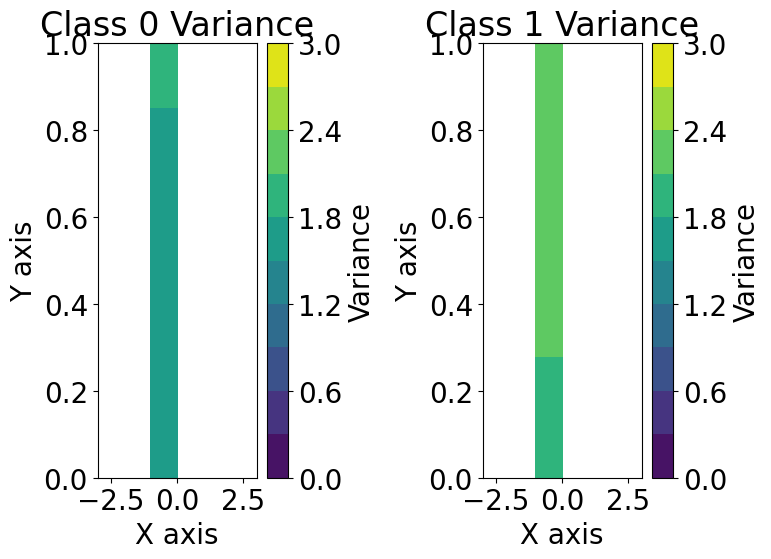

In [54]:
levels = np.linspace(0, 3, 11)
plt.figure(figsize=(8, 6))

x_values = test_x[:, 0].numpy()
y_values = test_y.numpy()
# y = np.linspace(test_y.min(), test_y.max(), 283)
x_mesh, y_mesh = np.meshgrid(x_values, y_values)

for class_idx in range(2):
    plt.subplot(1, 2, class_idx + 1)
    pred_var_copy = np.repeat(pred_var[class_idx][:, np.newaxis], x_mesh.shape[1], axis=1)
    # print(pred_var_copy)
    # pred_var_reshaped = pred_var_copy.reshape((2, 283, 283))
    # plt.contourf(x_mesh, y_mesh, pred_var_copy, levels=levels, cmap='viridis')

    pred_var_copy = np.repeat(pred_var[class_idx][:, np.newaxis], x_mesh.shape[1], axis=1)
    # pred_var_copy = np.repeat(pred_var_copy[:, :, np.newaxis], x_mesh.shape[1], axis=2)
    print(pred_var_copy.shape)
    print(pred_var_copy)
    plt.contourf(x_mesh, y_mesh, pred_var_copy, levels=levels, cmap='viridis')

    plt.colorbar(label='Variance')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title(f'Class {class_idx} Variance')


plt.tight_layout()
plt.show();


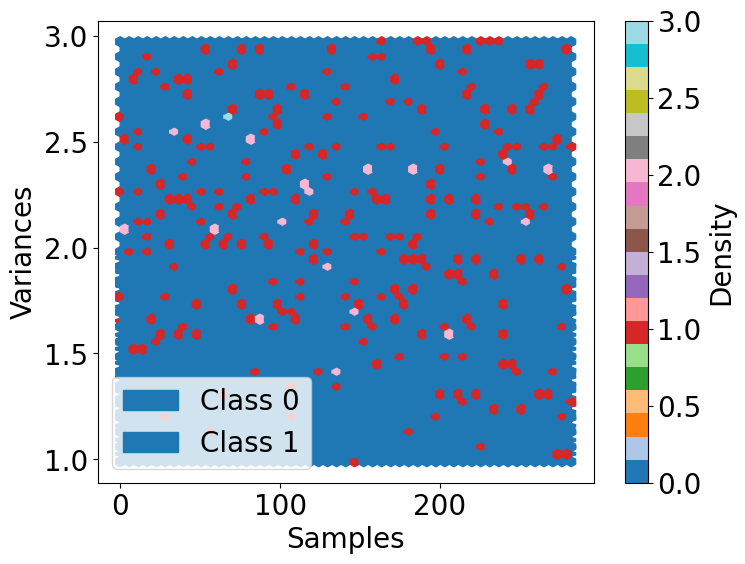

In [55]:
samples = np.arange(len(test_x))
vars_class0 = test_pred_variance2D[0]
vars_class1 = test_pred_variance2D[1]

plt.figure(figsize=(8, 6))
plt.hexbin(samples, vars_class0, gridsize=50, cmap='tab20', label='Class 0')
plt.hexbin(samples, vars_class1, gridsize=50, cmap='tab20', label='Class 1')
plt.colorbar(label='Density')
plt.xlabel('Samples')
plt.ylabel('Variances')
plt.legend()
plt.show()


/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_58767/1138995925.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


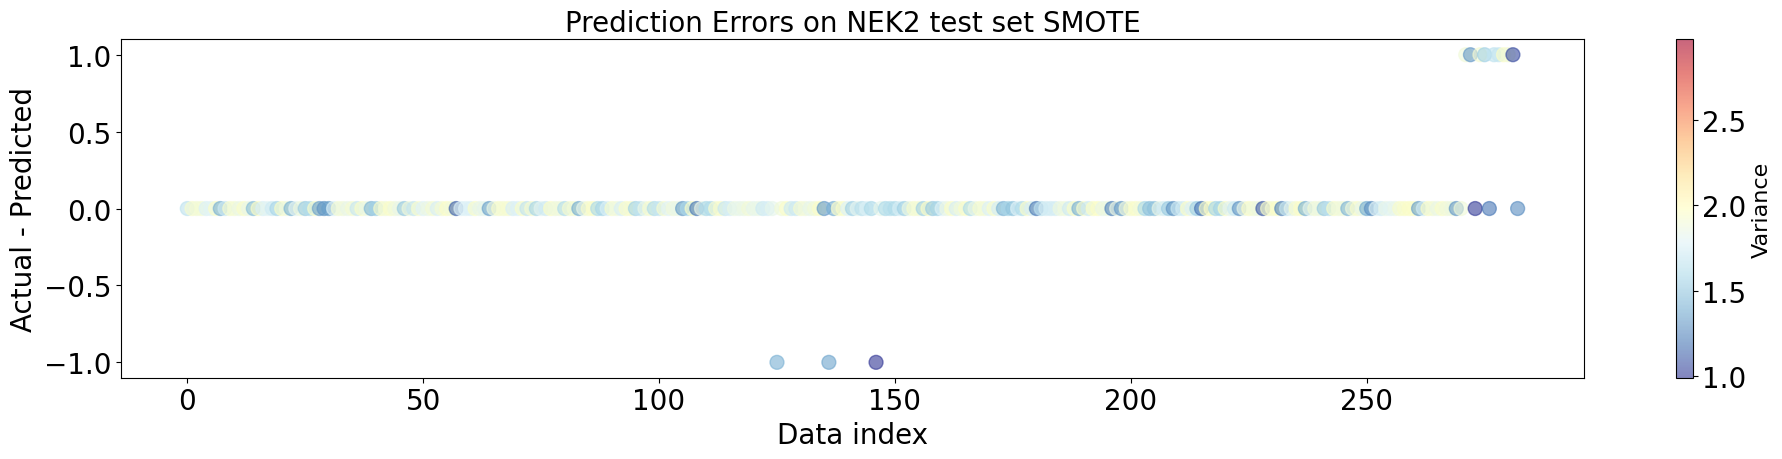

In [59]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance, s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_58767/3513342963.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


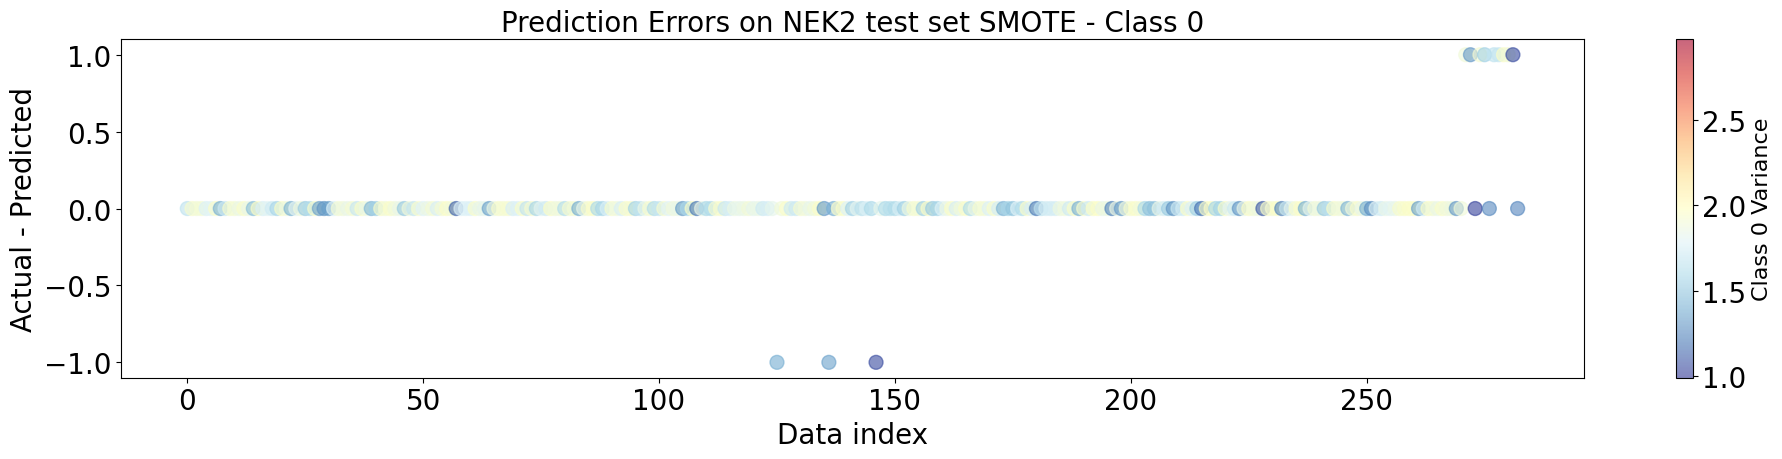

In [60]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE - Class 0",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance2D[0], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 0 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_40829/3654803106.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


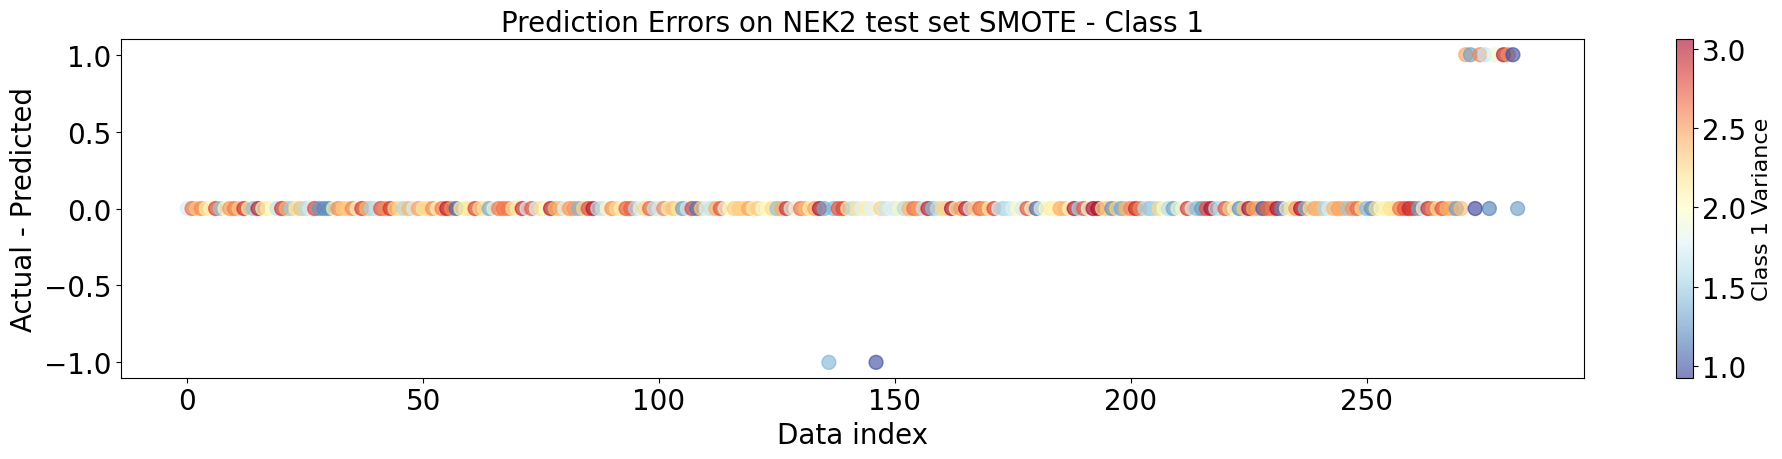

In [85]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE - Class 1",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance2D[1], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 1 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

# Saving Model Predictions

In [122]:
test_pred_means.numpy().shape
test_prediction = test_dist.loc.max(0)[1].numpy()
y_true = test_y_df.values.flatten()
test_observed_pred.mean.numpy()
test_pred_variance2D = test_observed_pred.variance.numpy()

train_observed_pred.variance.numpy().shape
test_pred_variance = [test_pred_variance2D[value][idx] for idx,value in enumerate(test_prediction)]
pred_samples = test_dist.sample(torch.Size((100,))).exp()
pred_samples.shape
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
probabilities[0,]


train_perf_df = pd.DataFrame()
test_perf_df = pd.DataFrame()

train_perf_df["mean_pred_class0"] = train_observed_pred.mean.numpy()[0,]
train_perf_df["mean_pred_class1"] = train_observed_pred.mean.numpy()[1,]
train_perf_df["y"] = train_y
train_perf_df["y_pred"] = train_pred_means.max(0)[1]
train_perf_df["var_pred_class0"] = train_observed_pred.variance.numpy()[0,]
train_perf_df["var_pred_class1"] = train_observed_pred.variance.numpy()[1,]
train_perf_df['pred_probability_class0'] = train_probabilities.numpy()[0,]
train_perf_df['pred_probability_class1'] = train_probabilities.numpy()[1,]

test_perf_df["mean_pred_class0"] = test_observed_pred.mean.numpy()[0,]
test_perf_df["mean_pred_class1"] = test_observed_pred.mean.numpy()[1,]
test_perf_df["y"] = test_y
test_perf_df["y_pred"] = test_pred_means.max(0)[1]
test_perf_df["var_pred_class0"] = test_observed_pred.variance.numpy()[0,]
test_perf_df["var_pred_class1"] = test_observed_pred.variance.numpy()[1,]
test_perf_df['pred_probability_class0'] = probabilities.numpy()[0,]
test_perf_df['pred_probability_class1'] = probabilities.numpy()[1,]

test_perf_df

,mean_pred_class0,mean_pred_class1,y,y_pred,var_pred_class0,var_pred_class1,pred_probability_class0,pred_probability_class1
0,-0.474381,-6.573988,0,0,1.653449,1.764008,0.990346,0.009654
1,-0.462296,-6.505222,0,0,1.927407,2.613243,0.986595,0.013405
2,-0.297475,-6.868537,0,0,1.902665,2.269560,0.991180,0.008820
3,-0.319220,-6.767580,0,0,1.908976,2.523780,0.991335,0.008665
4,-0.190827,-6.341446,0,0,1.770218,2.075796,0.994848,0.005152
...,...,...,...,...,...,...,...,...
278,-2.300257,-3.782100,1,0,1.685958,1.916098,0.720612,0.279388
279,-0.042569,-6.940609,1,0,1.952230,2.936967,0.990987,0.009013
280,0.009524,-7.061033,1,0,1.899298,2.482037,0.991292,0.008708
281,-2.515798,-3.410058,1,0,1.056123,1.028286,0.652829,0.347171


In [120]:
train_perf_df.to_csv("GPC_NEK2_Binding_train_perf.csv", index=False)
test_perf_df.to_csv("GPC_NEK2_Binding_test_perf.csv", index=False)

[271 272 273 274 275 276 277 278 279 280 281 282]


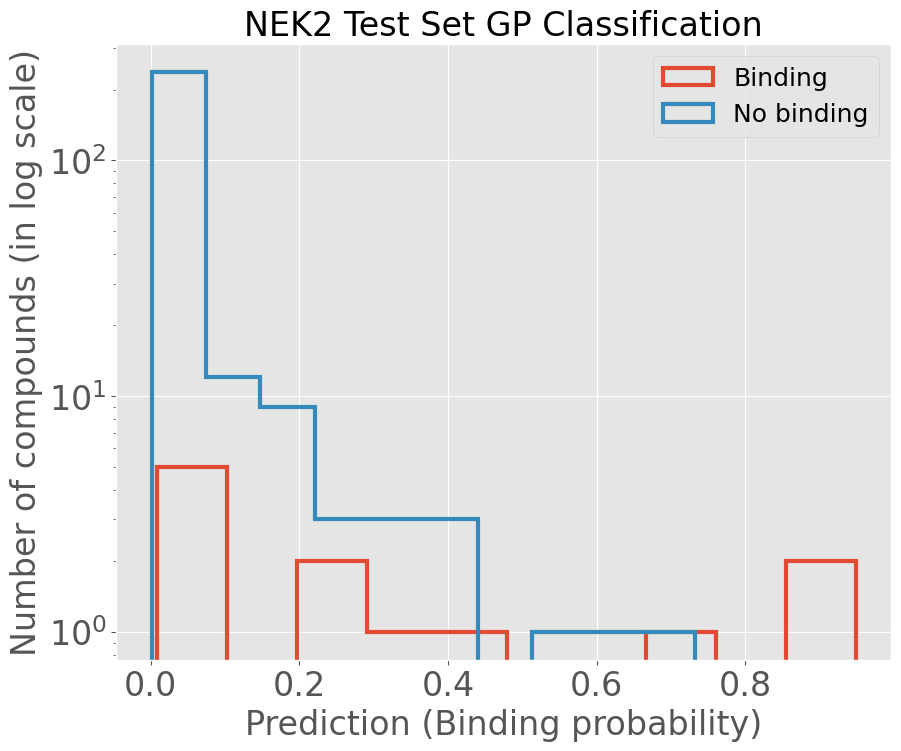

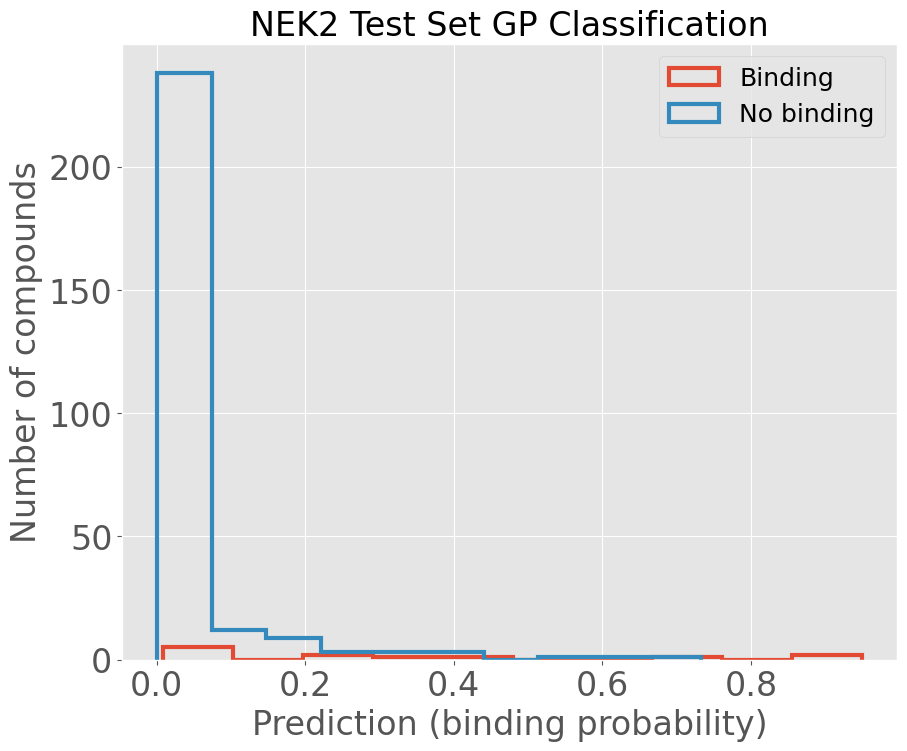

In [128]:
matplotlib.style.use('ggplot')
matplotlib.rc('xtick', labelsize=24)
matplotlib.rc('ytick', labelsize=24)
matplotlib.rc('axes', labelsize=24)
cbarFont = 52
clusterFont = 46
xyFont = 14
resolution = 20
fig_width = 10
fig_height = 8

idx_1 = np.where(test_perf_df.y == 1)[0]
idx_0 = np.where(test_perf_df.y == 0)[0]
print(idx_1)
# Histogram predictions without error bars:
fig, ax = plt.subplots(1,figsize=(fig_width, fig_height))
ax.hist(test_perf_df.pred_probability_class1[idx_1], histtype='step', linewidth=3, label='Binding')
ax.hist(test_perf_df.pred_probability_class1[idx_0], histtype='step', linewidth=3, label='No binding')
ax.set_xlabel('Prediction (Binding probability)')
ax.set_ylabel('Number of compounds (in log scale)')
plt.title("NEK2 Test Set GP Classification", fontsize=24)
plt.legend(fontsize=18)

plt.yscale('log')
plt.savefig('NEK2_binding_hist_prob_log.png')

# Histogram predictions without error bars:
fig, ax = plt.subplots(1,figsize=(fig_width, fig_height))
ax.hist(test_perf_df.pred_probability_class1[idx_1], histtype='step', linewidth=3, label='Binding')
ax.hist(test_perf_df.pred_probability_class1[idx_0], histtype='step', linewidth=3, label='No binding')
ax.set_xlabel('Prediction (binding probability)')
ax.set_ylabel('Number of compounds')
plt.title("NEK2 Test Set GP Classification", fontsize=24)
plt.legend(fontsize=18)
#plt.yscale('log')
plt.savefig('NEK2_binding_hist_prob.png')
plt.show()

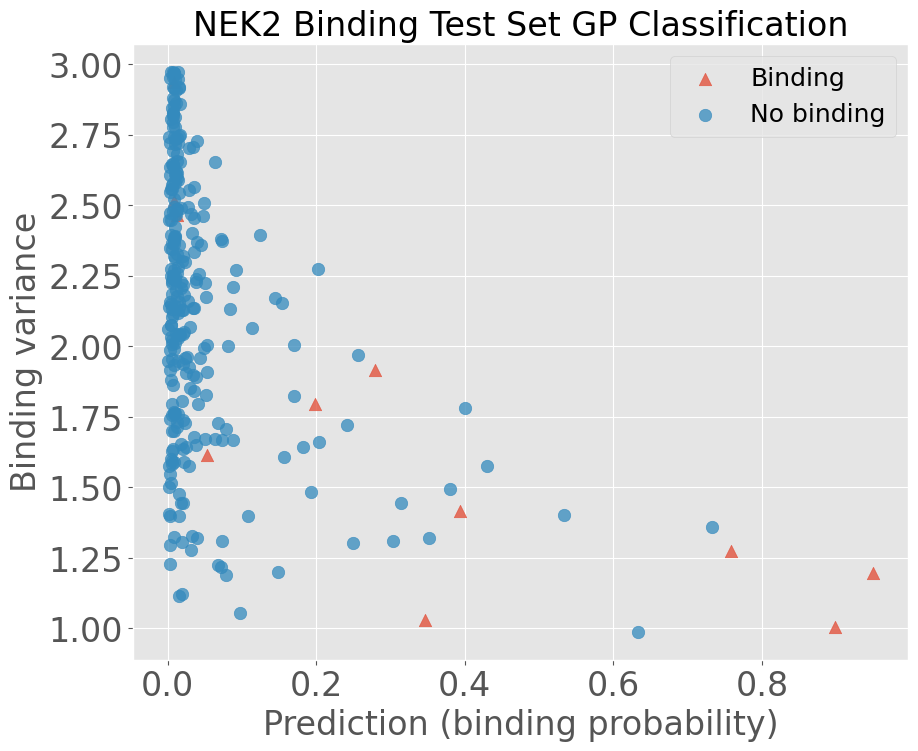

In [126]:

# Scatter plot
fig, ax = plt.subplots(1,figsize=(fig_width, fig_height))

ax.scatter(test_perf_df.pred_probability_class1[idx_1],
           test_perf_df.var_pred_class1[idx_1],
           label='Binding', marker='^', s=80, alpha=0.75)

ax.scatter(test_perf_df.pred_probability_class1[idx_0],
           test_perf_df.var_pred_class1[idx_0],
           label='No binding', marker='o', s=80, alpha=0.75)

ax.set_xlabel('Prediction (binding probability)')
ax.set_ylabel('Binding variance')
plt.title("NEK2 Binding Test Set GP Classification", fontsize=24)
plt.legend(fontsize=18)
plt.savefig('NEK2_binding_scatter_prob.png')

plt.show()


/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_58767/1221809171.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(np.arange(len(test_y)), test_pred, test_pred_variance, cmap='viridis')


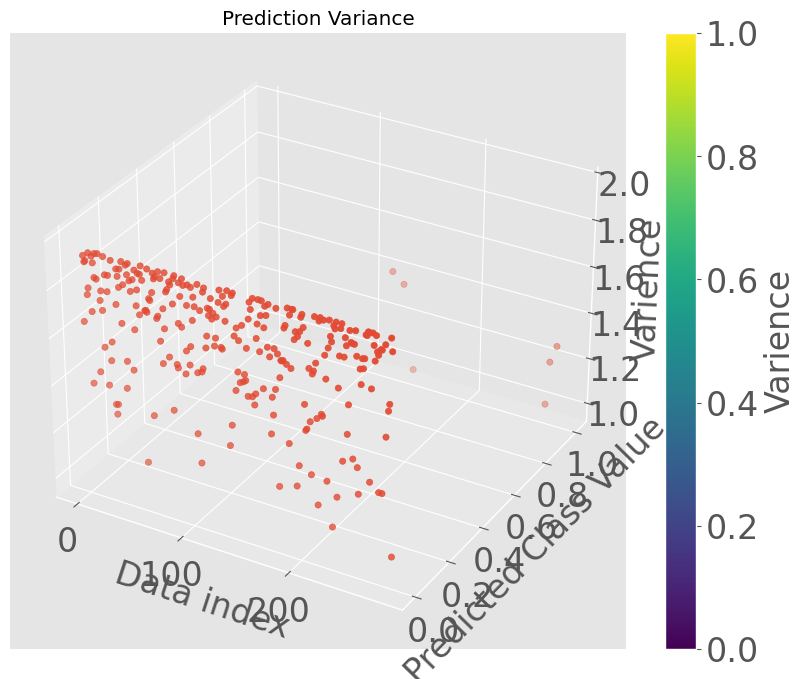

In [124]:
# scatter 3d? 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(np.arange(len(test_y)), test_pred, test_pred_variance, cmap='viridis')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Varience')

ax.set_xlabel('Data index')
ax.set_ylabel('Predicted Class Value')
ax.set_zlabel('Varience')
ax.set_title('Prediction Variance')
plt.show();


In [84]:
# class_0_variances = pred_var[0]
# class_1_variances = pred_var[1]

# x_min, x_max = test_x[:, 0].min() - 1, test_x[:, 0].max() + 1
# y_min, y_max = test_x[:, 1].min() - 1, test_x[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# print(xx.shape, yy.shape)
# plt.figure()
# plt.contourf(xx, yy, np.sqrt(pred_var[0].reshape(xx.shape)), alpha=0.8)
# plt.contourf(xx, yy, np.sqrt(pred_var[1].reshape(xx.shape)), alpha=0.8)
# plt.scatter(x_values[:, 0], x_values[:, 1], c=y_values, edgecolors='k')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.title('Contour Plot with Variances')
# plt.show()

In [ ]:
# train_var = train_observed_pred.variance.numpy().tolist()
# plt.figure(figsize=(10, 6))
# for class_idx in range(2):
#     class_variances = train_observed_pred.variance[class_idx].numpy() 
#     plt.hist(class_variances, bins=20, alpha=0.5, label=f'Class {class_idx}')

# plt.xlabel('Variance')
# plt.ylabel('Frequency')
# plt.title('Distribution of Variances for Each Class - TRAIN')
# plt.legend()
# plt.grid(True)
# plt.savefig('nek2train_hist.png')
# plt.show();


# plt.figure(figsize=(10, 6))
# for class_idx in range(2): 
#     class_variances = train_observed_pred.variance[class_idx].numpy() 
#     plt.hist(class_variances, bins=20, alpha=0.5, label=f'Class {class_idx}')
#     sns.violinplot(data=train_observed_pred.variance[class_idx].numpy().tolist(), inner="quartile")
# plt.xlabel('Class')

# plt.ylabel('Variance')
# plt.ylim(0,10)
# plt.legend()
# plt.title('Distribution of Variances for Each Class - TRAIN')
# plt.grid(True)
# plt.show();

# plt.figure(figsize=(10, 6))
# for i in range(len(train_var)):
#     sns.kdeplot(train_var[i], label=f'Class {i}')
# plt.xlabel('Variance')
# plt.ylabel('Density')
# plt.title('KDE Variances for Each Class - TRAIN')
# plt.legend()
# plt.grid(True)
# plt.show();

In [ ]:
# folds = [1] 
# for fold in folds: 
#     fold = str(fold)
#     trainx = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_trainX.csv')
#     trainy = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_trainY.csv')
#     testx = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_testX.csv')
#     testy = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_testY.csv')
#     # print(f'trainx :{trainx.shape}, trainy shape: {trainy.shape} \t testx: {testx.shape}, testy: {testy.shape}')
    
#     oversample_trial = SMOTE()
#     trial_train_x, trial_train_y_df = oversample_trial.fit_resample(trainx, trainy)
#     print(f'new trainx :{new_train_x_df.shape}, new trainy shape: {new_train_y_df.shape} \t testx df: {test_x_df.shape}, testy df: {test_y_df.shape}')
#     print(f'new trial trainx :{trial_train_x.shape}, new trial trainy shape: {trial_train_y_df.shape} \t testx df: {test_x_df.shape}, testy df: {test_y_df.shape}')
#     print(f'trial train same: {new_train_x_df.equals(trial_train_x)}')
#     print(f'test train same: {new_train_y_df.equals(trial_train_y_df)}')
#     print(f'trial test same: {test_x_df.equals(testx)}')
#     print(f'test test same: {test_y_df.equals(testy)}')
#     # print(list(new_train_x_df.values.flatten().tolist()))
#     # print(list(trial_train_x.values.flatten().tolist()))
#     diff_trainx = new_train_x_df.values != trial_train_x.values
#     which_diff_trainx = np.where(diff_trainx)
#     print(f"indices with differences in train x:", which_diff_trainx)
#     for i, val in enumerate(list(new_train_x_df.values.flatten().tolist())): 
#         other_val = list(trial_train_x.values.flatten().tolist())[i]
#         if (val != other_val): 
#             print(f'difference at index: {i}, new train y df: {val}, trial: {other_val}')
      
            